# Initliziation


## Set Global Variables


In [1]:
# set system
import sys
IN_COLAB = 'google.colab' in sys.modules
ABDUL_G_DRIVE = False

# set torch device
import torch 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Initlize Colab:

### Connect to Drive

In [2]:
# connect to drive
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')

  # set project path from drive
  if ABDUL_G_DRIVE:
    project_path = "/content/gdrive/MyDrive/00 Projects/AML"
    %cd -q $project_path 
    !pwd

Mounted at /content/gdrive
/content/gdrive/MyDrive/00 Projects/AML


### Install PyG in Colab 

In [3]:
# define dynamic function to install pyg
def install_pyg():
    try:
        import torch_geometric
    except:
        TORCH = torch.__version__.split('+')[0]
        CUDA = 'cu' + torch.version.cuda.replace('.', '')
        !pip install torch-scatter     -q -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
        !pip install torch-sparse      -q -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
        !pip install torch-cluster     -q -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
        !pip install torch-spline-conv -q -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
        !pip install torch-geometric   -q

# install
if IN_COLAB: install_pyg()

## Load Dependencies

In [4]:
# src 
from models import MLP, GCN, GAT
from random_split import random_split
from p_reg_loss import A_hat_computations, p_reg_loss
from lap_loss import lap_loss
from cp_loss import cp_loss
from label_smoothing import label_smoothing
from helper import visualize_Atlas, visualize_TSNE, visualize_CM, print_dataset, print_data

# packages
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score
from sklearn.manifold import TSNE
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import time

# Train, Test and Evaluation functions

### Train function

In [5]:
# Train func
def train(model, optimizer, criterion, data, train_mask, mu, reg_loss, p_reg_dict=None, num_classes = None):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    _, Z = model(data)     # Perform a single forward pass.    

    if reg_loss == 'ls_reg':
        smooth_label = label_smoothing(data.y[train_mask], num_classes, mu)
        loss_1 = criterion(Z[train_mask], smooth_label)
    else :
        loss_1 = criterion(Z[train_mask], data.y[train_mask])  # Compute the loss solely based on the training nodes.
        # to do! 

    if reg_loss == 'p_reg':
        loss_2 = p_reg_loss(Z, 
                        p_reg_dict['A_hat'], 
                        p_reg_dict['A_hat_mask'], 
                        p_reg_dict['N'], 
                        phi = p_reg_dict['phi'])
    elif reg_loss == 'lap_reg': 
        loss_2 = lap_loss(Z, data) 
    elif reg_loss == 'cp_reg': 
        loss_2 = cp_loss(Z)
    elif reg_loss == 'no_reg':
        loss_2 = 0
        assert mu == 0
    
    if reg_loss == 'ls_reg':
        loss = loss_1
    else :
        loss = loss_1 + mu * loss_2

    # to do!   

    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, Z

## Test Function:

In [6]:
# Test func: Using the early stopping method
def test(model, data, mask, criterion, mu, reg_loss, p_reg_dict=None, num_classes = None):
    # eval
    model.eval()
    _, Z = model(data)

    # cal loss
    if reg_loss != 'ls_reg':
        loss_1 = criterion(Z[mask], data.y[mask])  # Compute the loss solely based on the training nodes.
    else :
        smooth_label = label_smoothing(data.y[mask], num_classes, mu)
        loss_1 = criterion(Z[mask], smooth_label)
        # to do! 

    if reg_loss == 'p_reg':
      loss_2 = p_reg_loss(Z, 
                          p_reg_dict['A_hat'], 
                          p_reg_dict['A_hat_mask'],
                          p_reg_dict['N'], 
                          phi = p_reg_dict['phi'])
    elif reg_loss == 'lap_reg': loss_2 = lap_loss(Z, data) 
    elif reg_loss == 'cp_reg': loss_2 = cp_loss(Z)
    elif reg_loss == 'no_reg':
      loss_2 = 0
      assert mu == 0

    if reg_loss != 'ls_reg':
        loss = loss_1 + mu * loss_2
    else :
        loss = loss_1
        # to do!      

    # cal metrics
    y_pred = Z.argmax(dim=1)  # Use the class with highest probability.
    score = torch.softmax(Z, dim=1) # tis is for the roc_auc_score
    acc = accuracy_score    (y_true = data.y[mask].cpu().detach().numpy(), y_pred  = y_pred[mask].cpu().detach().numpy())
    rms = mean_squared_error(y_true = data.y[mask].cpu().detach().numpy(), y_pred  = y_pred[mask].cpu().detach().numpy(), squared=False)
    roc = roc_auc_score     (y_true = data.y[mask].cpu().detach().numpy(), y_score = score [mask, :].cpu().detach().numpy(), multi_class='ovr')    

    return loss, Z, acc, rms, roc, y_pred

## Evaluation function

In [ ]:
# def evaluation( A = None, # int 
#                 B = None, # int 
#                 mu = None, # float 
#                 seed = None, # float 
#                 As = None, # int list 
#                 Bs = None, # int list 
#                 mus = None, # float list 
#                 seeds = None, # float list 
#                 reg_loss = None, # str: 'p_reg', 'lap_reg', 'cp_reg', 'no_reg' 
#                 p_reg_phi = None, # str: 'cross_entropy', 'squared_error', 'kl_divergence' #####################
#                 datasets = ['Cora', 'CiteSeer', 'PubMed'], # str list
#                 epochs = 200, # int
#                 verbose = True # bolean
#                 ):

#     # check A and B arg.
#     if (A is not None) | (B is not None):
#         assert A is not None, "A is missing" 
#         assert B is not None, "B is missing" 
#         assert (seed is not None) | (seeds is not None), "seed or seeds is missing"
#         assert As is None, "As should not be given"
#         assert Bs is None, "Bs should not be given"

#     # check mu input arg.
#     if mu is not None:
#         if mu == 0:
#             assert reg_loss == 'no_reg', "reg_loss should be 'no_reg'"

#     # check seed input arg.
#     if seed is not None: 
#         assert seeds is None, "seeds should not be given"

#     # check reg_loss input arg.
#     if reg_loss is not None:
#         assert reg_loss in ['p_reg', 'lap_reg', 'cp_reg', 'ls_reg', 'no_reg'], "check reg_losse arg."    
#         if reg_loss == 'no_reg':
#             assert mu == 0, "mu should be 0"
 
#     # check p_reg_phi input arg.
#     if p_reg_phi is not None:
#         assert p_reg_phi in ['cross_entropy', 'squared_error', 'kl_divergence'], 'check p_reg_phi arg.'
#         assert reg_loss == 'p_reg' , "reg_loss should be p_reg'"

#     # check lists input args
#     if mus is not None:
#         assert mu is None, "mu should not be given"
#         params, params_len, params_tag = mus, len(mus), 'Mus'
#         if verbose: print(f'Training with {reg_loss} with different "Mus":')

#     elif seeds is not None:
#         assert seed is None, "seed should not be given"
#         params, params_len, params_tag = seeds, len(seeds), 'Seeds'
#         if verbose: print(f'Training with {reg_loss} with different "Seeds":')

#     elif (As is not None) | (Bs is not None): 
#         assert seed is not None, "seed is missing" 
#         assert As is not None, "As are missing"
#         assert Bs is not None, "Bs are missing"
#         assert len(As) == len (Bs), "As and Bs do not have the same length" 
#         assert A is None, "A should not be given"
#         assert B is None, "B should not be given"
#         params, params_len, params_tag = As, len(As),'Training Nodes'
#         if verbose: print(f'Training with {reg_loss} with different "Number Training Nodes":')

#     else:
#         params, params_len, params_tag = [], 1, 'No Params Loop'
#         if verbose: print(f'Training with {reg_loss} with {params_tag}')
#         assert (mu is not None) & (reg_loss is not None), 'mu and reg_loss are missing' 

#     # evaluation Storage
#     Results = {}
    
#     # loop over datasets
#     for dataset_name in datasets: 
#         # define dataset
#         if verbose: print(f'=========================\n{dataset_name}:')
#         if dataset_name == 'Cora':
#             if ABDUL_G_DRIVE: dataset = Planetoid(root=f'data/Planetoid', name='Cora', transform=NormalizeFeatures())
#             else: dataset = Planetoid(root=f'/tmp/Cora', name='Cora', transform=NormalizeFeatures())
#         elif dataset_name == 'CiteSeer':
#             if ABDUL_G_DRIVE: dataset = Planetoid(root=f'data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())
#             else: dataset = Planetoid(root=f'/tmp/CiteSeer', name='CiteSeer', transform=NormalizeFeatures())
#         elif dataset_name == 'PubMed':
#             if ABDUL_G_DRIVE: dataset = Planetoid(root=f'data/Planetoid', name='PubMed', transform=NormalizeFeatures())         
#             else: dataset = Planetoid(root=f'/tmp/PubMed', name='PubMed', transform=NormalizeFeatures())         
#         else:
#             raise NotImplementedError('Only Cora, CiteSeer and PubMed datasets are supported')
        
#         # define data
#         data = dataset[0]
#         data = data.to(device)


#         # calc number of classes if reg_loss == 'ls_reg'
#         num_classes = dataset.num_classes if reg_loss == 'ls_reg' else None

#         # calc split here when params_tag == 'Mus' or 'No Params Loop':
#         if (params_tag == 'Mus') | (params_tag == 'No Params Loop'):
#             if (seed is not None) & (A is not None) & (B is not None):
#                 train_mask, val_mask, test_mask = random_split(dataset, A, B, seed)
#                 # to do!
#             else:
#                 train_mask, val_mask, test_mask = data.train_mask, data.val_mask, data.test_mask
        
#         # calc A_hat as it's training invariant 
#         if reg_loss == 'p_reg':
#             A_hat, A_hat_mask, N = A_hat_computations(data)
#             p_reg_dict = {'A_hat': A_hat, 
#                           'A_hat_mask': A_hat_mask, 
#                           'N': N, 
#                           'phi': 'cross_entropy' if p_reg_phi is None else p_reg_phi}  
#         else: 
#             p_reg_dict = None

#         # define test evaluation metrices
#         Results[dataset_name+'_acc' ] = []
#         Results[dataset_name+'_rms' ] = []
#         Results[dataset_name+'_roc' ] = []
#         Results[dataset_name+'_loss'] = []
#         Results[dataset_name+'_Z'   ] = []
#         Results[dataset_name+'_test_mask'] = []

#         # loop over params
#         for i in range(params_len):
#             # define model parameters        
#             if params_tag == 'Mus': 
#                 mu = mus[i]
#             elif params_tag == 'Seeds': 
#                 seed = seeds[i]
#                 # calc the split
#                 if (A is not None) & (B is not None):
#                     train_mask, val_mask, test_mask = random_split(dataset, A, B, seed)
#                     # to do!
#                 else:
#                     train_mask, val_mask, test_mask = data.train_mask, data.val_mask, data.test_mask
#             elif params_tag == 'Training Nodes': 
#                 A, B = As[i], Bs[i]
#                 # calc the split
#                 if seed is not None:
#                     train_mask, val_mask, test_mask = random_split(dataset, A, B, seed)
#                     # to do! 
#                 else:
#                     train_mask, val_mask, test_mask = data.train_mask, data.val_mask, data.test_mask


#             # define MOC
#             model = GCN(dataset,
#                         hidden_channels=64, 
#                         seed = 0 if seed is None else seed).to(device)
#             # to do! 
#             optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
#             criterion = torch.nn.CrossEntropyLoss()

#             # loop over epochs
#             Val_Acc, Train_Loss = -np.inf, -np.inf
#             for epoch in range(epochs):
#                 # train
#                 train_loss, _ = train(model, optimizer, criterion, data, train_mask, mu, reg_loss, p_reg_dict, num_classes)   
#                 # test
#                 with torch.no_grad():
#                   _, _, val_acc, _, _, _ = test(model, data, val_mask, criterion, mu, reg_loss, p_reg_dict, num_classes)
#                   if (val_acc > Val_Acc):
#                     test_loss, test_Z, test_acc, test_rms, test_roc, _ = test(model, data, test_mask, criterion, mu, reg_loss, p_reg_dict, num_classes)
#                     Train_Loss = train_loss
#                     Val_Acc = val_acc
#                     # to do!
#             # save test metrices, loss and embadding
#             Results[dataset_name+'_acc' ].append(test_acc)
#             Results[dataset_name+'_rms' ].append(test_rms)
#             Results[dataset_name+'_roc' ].append(test_roc)
#             Results[dataset_name+'_loss'].append(test_loss)
#             Results[dataset_name+'_Z'   ].append(test_Z)
#             Results[dataset_name+'_test_mask'].append(test_mask)
            
#             # Print 
#             condition = ((verbose) & (i % 2 == 0)) if (params_len < 10) else ((verbose) & (i % 5 == 0))
#             precent = int(i/params_len*100)
#             if condition:
#                 if params_tag == 'Training Nodes': 
#                     print(f'{precent}%: A,B= ({A},{B}), train_loss: {Train_Loss:.4f}')            
#                 elif params_tag == 'Seeds': 
#                     print(f'{precent}%: seed= {seed}, train_loss: {Train_Loss:.4f}')            
#                 elif params_tag == 'Mus': 
#                     print(f'{precent}%: mu= {mu:.4f}, train_loss: {Train_Loss:.4f}')
#                 print(f'    Test_acc: {test_acc:.4f}, Test_rms: {test_rms:.4f}, Test_roc: {test_roc:.4f}')

#     return Results, params, params_tag, reg_loss

In [26]:
def evaluation( A = None, # int 
                B = None, # int 
                mu = None, # float 
                seed = None, # float 
                As = None, # int list 
                Bs = None, # int list 
                mus = None, # float list 
                seeds = None, # float list 
                reg_loss = None, # str: 'p_reg', 'lap_reg', 'cp_reg', 'no_reg' 
                p_reg_phi = None, # str: 'cross_entropy', 'squared_error', 'kl_divergence'
                model_name = 'GCN', # str: 'GCN','GAT','MLP'
                datasets = ['Cora', 'CiteSeer', 'PubMed'], # str list
                epochs = 200, # int
                patience = 100, # int 
                verbose = True, # bolean
                ):

    # check A and B arg.
    if (A is not None) | (B is not None):
        assert A is not None, "A is missing" 
        assert B is not None, "B is missing" 
        assert (seed is not None) | (seeds is not None), "seed or seeds is missing"
        assert As is None, "As should not be given"
        assert Bs is None, "Bs should not be given"

    # check mu input arg.
    if mu is not None:
        if mu == 0:
            assert reg_loss == 'no_reg', "reg_loss should be 'no_reg'"

    # check seed input arg.
    if seed is not None: 
        assert seeds is None, "seeds should not be given"
        torch.manual_seed(seed)
        
    # check reg_loss input arg.
    if reg_loss is not None:
        assert reg_loss in ['p_reg', 'lap_reg', 'cp_reg', 'ls_reg', 'no_reg'], "check reg_losse arg."    
        if reg_loss == 'no_reg':
            assert mu == 0, "mu should be 0"
 
    # check p_reg_phi input arg.
    if p_reg_phi is not None:
        assert p_reg_phi in ['cross_entropy', 'squared_error', 'kl_divergence'], 'check p_reg_phi arg.'
        assert reg_loss == 'p_reg' , "reg_loss should be p_reg'"

    # check lists input args
    if mus is not None:
        assert mu is None, "mu should not be given"
        params, params_len, params_tag = mus, len(mus), 'Mus'
        if verbose: print(f'Training with {reg_loss} with different "Mus":')

    elif seeds is not None:
        assert seed is None, "seed should not be given"
        params, params_len, params_tag = seeds, len(seeds), 'Seeds'
        if verbose: print(f'Training with {reg_loss} with different "Seeds":')

    elif (As is not None) | (Bs is not None): 
        assert seed is not None, "seed is missing" 
        assert As is not None, "As are missing"
        assert Bs is not None, "Bs are missing"
        assert len(As) == len (Bs), "As and Bs do not have the same length" 
        assert A is None, "A should not be given"
        assert B is None, "B should not be given"
        params, params_len, params_tag = As, len(As),'Training Nodes'
        if verbose: print(f'Training with {reg_loss} with different "Number Training Nodes":')

    else:
        params, params_len, params_tag = [], 1, 'No Params Loop'
        if verbose: print(f'Training with {reg_loss} with {params_tag}')
        assert (mu is not None) & (reg_loss is not None), 'mu and reg_loss are missing' 

    # evaluation Storage
    Results = {}
    
    # loop over datasets
    for dataset_name in datasets: 
        # define dataset
        if verbose: print(f'=========================\n{dataset_name}:')
        if dataset_name == 'Cora':
            if ABDUL_G_DRIVE: dataset = Planetoid(root=f'data/Planetoid', name='Cora', transform=NormalizeFeatures())
            else: dataset = Planetoid(root=f'/tmp/Cora', name='Cora', transform=NormalizeFeatures())
        elif dataset_name == 'CiteSeer':
            if ABDUL_G_DRIVE: dataset = Planetoid(root=f'data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())
            else: dataset = Planetoid(root=f'/tmp/CiteSeer', name='CiteSeer', transform=NormalizeFeatures())
        elif dataset_name == 'PubMed':
            if ABDUL_G_DRIVE: dataset = Planetoid(root=f'data/Planetoid', name='PubMed', transform=NormalizeFeatures())         
            else: dataset = Planetoid(root=f'/tmp/PubMed', name='PubMed', transform=NormalizeFeatures())         
        else:
            raise NotImplementedError('Only Cora, CiteSeer and PubMed datasets are supported')
        
        # define data
        data = dataset[0]
        data = data.to(device)

        # calc number of classes if reg_loss == 'ls_reg'
        num_classes = dataset.num_classes

        # calc split here when params_tag == 'Mus' or 'No Params Loop':
        if (params_tag == 'Mus') | (params_tag == 'No Params Loop'):
            if (seed is not None) & (A is not None) & (B is not None):
                train_mask, val_mask, test_mask = random_split(dataset, A, B, seed)
                train_mask = train_mask.to(device)
                val_mask = val_mask.to(device)
                test_mask = test_mask.to(device)
                assert sum(train_mask)  == num_classes*A
                assert sum(val_mask)  == num_classes*B
            else:
                train_mask, val_mask, test_mask = data.train_mask, data.val_mask, data.test_mask
        
        # calc A_hat as it's training invariant 
        if reg_loss == 'p_reg':
            A_hat, A_hat_mask, N = A_hat_computations(data)
            p_reg_dict = {'A_hat': A_hat, 
                          'A_hat_mask': A_hat_mask, 
                          'N': N, 
                          'phi': 'cross_entropy' if p_reg_phi is None else p_reg_phi}  
        else: 
            p_reg_dict = None

        # define test evaluation metrices
        Results[dataset_name+'_acc' ] = []
        Results[dataset_name+'_rms' ] = []
        Results[dataset_name+'_roc' ] = []
        Results[dataset_name+'_loss'] = []
        Results[dataset_name+'_Z'   ] = []
        Results[dataset_name+'_test_mask'] = []

        # loop over params
        for i in range(params_len):

            # define model parameters        
            if params_tag == 'Mus': 
                mu = mus[i]
            elif params_tag == 'Seeds': 
                seed = seeds[i]
                torch.manual_seed(seed)
                # calc the split
                if (A is not None) & (B is not None):
                    train_mask, val_mask, test_mask = random_split(dataset, A, B, seed)
                    train_mask = train_mask.to(device)
                    val_mask = val_mask.to(device)
                    test_mask = test_mask.to(device)
                    assert sum(train_mask)  == num_classes*A
                    assert sum(val_mask)  == num_classes*B
                else:
                    train_mask, val_mask, test_mask = data.train_mask, data.val_mask, data.test_mask
            elif params_tag == 'Training Nodes': 
                A, B = As[i], Bs[i]
                # calc the split
                if seed is not None:
                    train_mask, val_mask, test_mask = random_split(dataset, A, B, seed)
                    train_mask = train_mask.to(device)
                    val_mask = val_mask.to(device)
                    test_mask = test_mask.to(device)
                    assert sum(train_mask)  == num_classes*A
                    assert sum(val_mask)  == num_classes*B
                else:
                    train_mask, val_mask, test_mask = data.train_mask, data.val_mask, data.test_mask

            # define MOC
            if model_name == 'GCN':
                model = GCN(dataset, hidden_channels=64, seed = 0 if seed is None else seed).to(device) # 16 , 64 
            elif model_name == 'GAT':
                model = GAT(dataset, hidden_channels=16, seed = 0 if seed is None else seed).to(device) # 8 , 16
            elif model_name == 'MLP':
                model = MLP(dataset, hidden_channels=64, seed = 0 if seed is None else seed).to(device) # 16 , 64       
            else: 
                raise NotImplementedError('Only GCA, GAT and MLP models are supported')
            optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
            criterion = torch.nn.CrossEntropyLoss()


            Val_Acc, Train_Loss, Epoch, Break_Epoch  = -np.inf, -np.inf, -1, -1
            for epoch in range(epochs):
                # train
                train_loss, _ = train(model, optimizer, criterion, data, train_mask, mu, reg_loss, p_reg_dict, num_classes)   
                # test
                with torch.no_grad():
                    _, _, val_acc, _, _, _ = test(model, data, val_mask, criterion, mu, reg_loss, p_reg_dict, num_classes)

                    if val_acc > Val_Acc: 
                        Test_Loss, Test_Z, Test_Acc, Test_RMS, Test_ROC, _ = test(model, data, test_mask, criterion, mu, reg_loss, p_reg_dict, num_classes)
                        Epoch, Train_Loss, Val_Acc = epoch, train_loss , val_acc
                        wait = 0
                    else:
                        wait += 1

            # save test metrices, loss and embadding
            Results[dataset_name+'_acc' ].append(Test_Acc)
            Results[dataset_name+'_rms' ].append(Test_RMS)
            Results[dataset_name+'_roc' ].append(Test_ROC)
            Results[dataset_name+'_loss'].append(Test_Loss)
            Results[dataset_name+'_Z'   ].append(Test_Z)
            Results[dataset_name+'_test_mask'].append(test_mask)
            
            # Print 
            condition = ((verbose) & (i % 2 == 0)) if (params_len < 10) else ((verbose) & (i % 5 == 0))
            precent = int(i/params_len*100)
            if condition:
                if params_tag == 'Training Nodes': 
                    print(f'{precent}%: A,B= ({A},{B}), train_loss: {Train_Loss:.4f}, best_epoch: {Epoch}, break_epoch: {Break_Epoch}')
                elif params_tag == 'Seeds': 
                    print(f'{precent}%: seed= {seed}, train_loss: {Train_Loss:.4f}, best_epoch: {Epoch}, break_epoch: {Break_Epoch}')
                elif params_tag == 'Mus': 
                    print(f'{precent}%: mu= {mu:.4f}, train_loss: {Train_Loss:.4f}, best_epoch: {Epoch}, break_epoch: {Break_Epoch}')
                print(f'    Test_acc: {Test_Acc:.4f}')

    return Results, params, params_tag, reg_loss

# Auxiliary Functions

## Viziual Report Function

In [9]:
# viz report:  metrices vs params for the 3 datasets on test
def report_vis(Results, params, params_tag, reg_loss, datasets  = ['Cora', 'CiteSeer', 'PubMed']):
    # Auxiliary function for ordring list w.r.t another list
    def aux_sort(lst,params):
          return [i for _,i in sorted(zip(params,lst))]
    # Set figure params
    colors    = ['green', 'blue', 'red'][0:len(datasets)]
    tags      = ['acc', 'rms', 'roc']
    titles    = ['Accuracy', 'RMS', 'ROC-AUC']
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    plt.suptitle(f"{params_tag.capitalize()} Vs. Evaluation Metrics",fontsize=18)
    for i_tag,tag in enumerate(tags):    
        for i_data,dataset_name in enumerate(datasets):
          axs[i_tag].plot(sorted(params),aux_sort(Results[f'{dataset_name}_{tag}'],params), color=colors[i_data], marker='o', label=f'{dataset_name}')
          axs[i_tag].legend()
          axs[i_tag].set_title(f'{titles[i_tag]}')
          axs[i_tag].set_xlabel(params_tag)
          axs[i_tag].set_xticks(sorted(params))
          axs[i_tag].set_xticklabels(sorted(np.round(params,2) if (type(params)==np.ndarray) else params), rotation='vertical')
          axs[i_tag].set_ylabel(f'{tags[i_tag]}')
          axs[i_tag].grid(True)
    
    caption =  f"The figure shows: {params_tag.capitalize()} Vs. Accuracy, RMS and ROC-AUC for the 3 datasets.\n"+\
                "The model is evaluated with "+ reg_loss +" on test data." 
    plt.figtext(0.5, -0.2, caption, wrap=True, horizontalalignment='center', fontsize=12)
    plt.show()

## Stats Report Function

In [10]:
# stats report: best params for the 3 datasets on test
def report_stats(Results, params, params_tag, datasets  = ['Cora', 'CiteSeer', 'PubMed']):
    # Set stats params
    tags      = ['acc', 'rms', 'roc']
    titles    = ['Accuracy', 'RMS', 'ROC-AUC']
    for dataset_name in datasets:
        print(f'========= {dataset_name}:')
        for tag in tags:
            if tag != 'rms':
                best = params[np.argmax(Results[f'{dataset_name}_{tag}'])]
                best = np.round(best, 3) if ((type(best) == np.float64) or (type(best) == float)) else best
                print(f"    {tag} best {params_tag} on test: {best}")
            else:
                best = params[np.argmin(Results[f'{dataset_name}_{tag}'])]
                best = np.round(best, 3) if ((type(best) == np.float64) or (type(best) == float)) else best
                print(f"    {tag} best {params_tag} on test: {best}")

## Load Dataset

In [11]:
def load_dataset(dataset_name):
    # define dataset
    if dataset_name == 'Cora':
        if ABDUL_G_DRIVE: dataset = Planetoid(root=f'data/Planetoid', name='Cora', transform=NormalizeFeatures())
        else: dataset = Planetoid(root=f'/tmp/Cora', name='Cora', transform=NormalizeFeatures())
    elif dataset_name == 'CiteSeer':
        if ABDUL_G_DRIVE: dataset = Planetoid(root=f'data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())
        else: dataset = Planetoid(root=f'/tmp/CiteSeer', name='CiteSeer', transform=NormalizeFeatures())
    elif dataset_name == 'PubMed':
        if ABDUL_G_DRIVE: dataset = Planetoid(root=f'data/Planetoid', name='PubMed', transform=NormalizeFeatures())         
        else: dataset = Planetoid(root=f'/tmp/PubMed', name='PubMed', transform=NormalizeFeatures()) 
    else:
        raise NotImplementedError('Only Cora, CiteSeer and PubMed datasets are supported')
    return dataset

## Clear variable Function

In [12]:
def clear():
    # clear varibles
    global A, B, mu, seed  
    global As, Bs, mus, seeds 
    global reg_loss, p_reg_phi
    global epochs, datasets, verbose
    A = None
    B = None  
    mu = None  
    seed = None  
    As = None 
    Bs = None  
    mus = None  
    seeds = None  
    reg_loss = None 
    p_reg_phi = None 
    epochs = 200
    datasets = ['Cora', 'CiteSeer', 'PubMed']
    verbose = True

# Analysis 00 (Simple run)

## Minimum case runs

In [17]:
Results, params, params_tag, reg_loss = evaluation(mu=0, reg_loss='no_reg')

Training with no_reg with No Params Loop
Cora:
    Test_acc: 0.8210
CiteSeer:
    Test_acc: 0.7170
PubMed:
    Test_acc: 0.7850


In [18]:
Results, params, params_tag, reg_loss = evaluation(mu=0.5, reg_loss='p_reg')

Training with p_reg with No Params Loop
Cora:
    Test_acc: 0.8240
CiteSeer:
    Test_acc: 0.7450
PubMed:
    Test_acc: 0.7850


# Aanalysis 01 (Without P-Reg)

## Fixed A and B with different Seeds
L03 P02 Q02


In [19]:
# set parameters
clear()
reg_loss = 'no_reg'
mu       = 0
A        = 20
B        = 30
seeds    = np.arange(10)

In [20]:
# train and evaluate 
Results, params, params_tag, reg_loss = evaluation(A = A, B = B, mu= mu, seeds = seeds, reg_loss = reg_loss)

Training with no_reg with different "Seeds":
Cora:
0%: seed= 0, train_loss: 0.2080, best_epoch: 127, break_epoch: -1
    Test_acc: 0.8066
50%: seed= 5, train_loss: 0.1793, best_epoch: 159, break_epoch: -1
    Test_acc: 0.8142
CiteSeer:
0%: seed= 0, train_loss: 0.6003, best_epoch: 61, break_epoch: -1
    Test_acc: 0.6888
50%: seed= 5, train_loss: 0.4858, best_epoch: 71, break_epoch: -1
    Test_acc: 0.7040
PubMed:
0%: seed= 0, train_loss: 0.2099, best_epoch: 58, break_epoch: -1
    Test_acc: 0.7803
50%: seed= 5, train_loss: 0.1842, best_epoch: 65, break_epoch: -1
    Test_acc: 0.7911


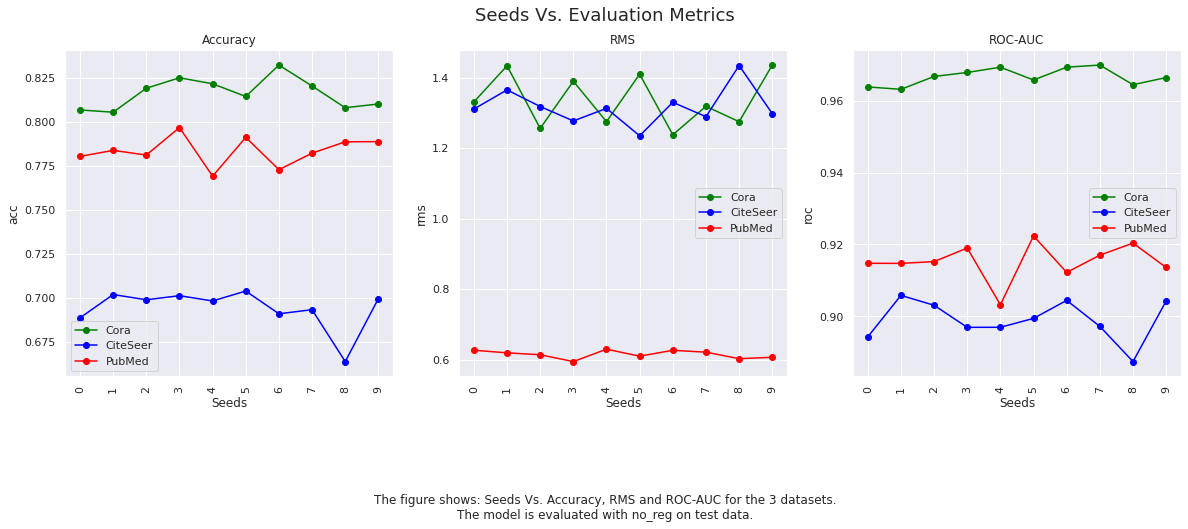

In [21]:
# report vis
report_vis(Results, params, params_tag, reg_loss)

In [22]:
# report stats
report_stats(Results, params, params_tag)

========= Cora:
    acc best Seeds on test: 6
    rms best Seeds on test: 6
    roc best Seeds on test: 7
========= CiteSeer:
    acc best Seeds on test: 5
    rms best Seeds on test: 5
    roc best Seeds on test: 1
========= PubMed:
    acc best Seeds on test: 3
    rms best Seeds on test: 3
    roc best Seeds on test: 5


## Fixed seed with different As and Bs
L03 P02 Q03


In [27]:
# set parameters
clear()
reg_loss = 'no_reg'
mu = 0
seed = 3
As = [20, 30, 40, 50, 60] 
Bs = np.array(As) + 10

In [28]:
# train an evaluate
Results, params, params_tag, reg_loss = evaluation(As = As, Bs = Bs, mu = mu, seed = seed, reg_loss = reg_loss)

Training with no_reg with different "Number Training Nodes":
Cora:
0%: A,B= (20,30), train_loss: 0.5618, best_epoch: 47, break_epoch: -1
    Test_acc: 0.8249
40%: A,B= (40,50), train_loss: 0.3310, best_epoch: 107, break_epoch: -1
    Test_acc: 0.8388
80%: A,B= (60,70), train_loss: 0.4490, best_epoch: 85, break_epoch: -1
    Test_acc: 0.8476
CiteSeer:
0%: A,B= (20,30), train_loss: 0.2082, best_epoch: 189, break_epoch: -1
    Test_acc: 0.7014
40%: A,B= (40,50), train_loss: 0.6606, best_epoch: 67, break_epoch: -1
    Test_acc: 0.7173
80%: A,B= (60,70), train_loss: 0.9055, best_epoch: 52, break_epoch: -1
    Test_acc: 0.7244
PubMed:
0%: A,B= (20,30), train_loss: 0.1931, best_epoch: 62, break_epoch: -1
    Test_acc: 0.7966
40%: A,B= (40,50), train_loss: 0.1820, best_epoch: 99, break_epoch: -1
    Test_acc: 0.8143
80%: A,B= (60,70), train_loss: 0.2052, best_epoch: 106, break_epoch: -1
    Test_acc: 0.8046


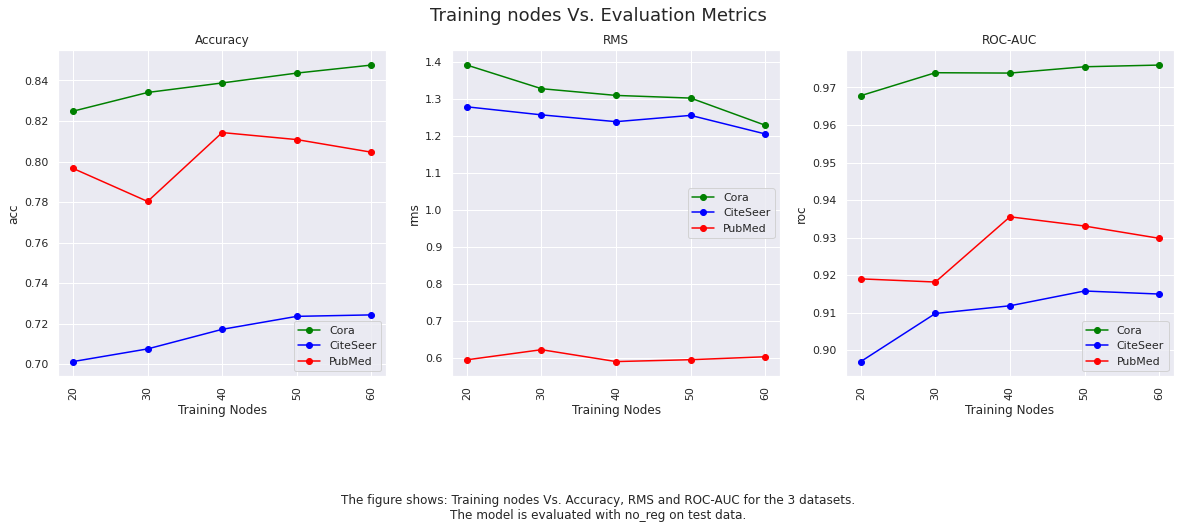

In [29]:
# report vis
report_vis(Results, params, params_tag, reg_loss)

In [30]:
# report stats
report_stats(Results, params, params_tag)

========= Cora:
    acc best Training Nodes on test: 60
    rms best Training Nodes on test: 60
    roc best Training Nodes on test: 60
========= CiteSeer:
    acc best Training Nodes on test: 60
    rms best Training Nodes on test: 60
    roc best Training Nodes on test: 50
========= PubMed:
    acc best Training Nodes on test: 40
    rms best Training Nodes on test: 40
    roc best Training Nodes on test: 40


# Analysis 02 (With P-Reg)

## Original split different Mus 
L03 P02 Q01


In [31]:
# set parameters
clear()
reg_loss='p_reg'
p_reg_phi = 'cross_entropy'
mus = np.linspace(0,1,21)

In [32]:
# train and evaluate 
Results, params, params_tag, reg_loss = evaluation(mus=mus, reg_loss=reg_loss, p_reg_phi = p_reg_phi)

Training with p_reg with different "Mus":
Cora:
0%: mu= 0.0000, train_loss: 0.6252, best_epoch: 39, break_epoch: -1
    Test_acc: 0.8210
23%: mu= 0.2500, train_loss: 0.3409, best_epoch: 178, break_epoch: -1
    Test_acc: 0.8260
47%: mu= 0.5000, train_loss: 1.4842, best_epoch: 36, break_epoch: -1
    Test_acc: 0.8240
71%: mu= 0.7500, train_loss: 0.5227, best_epoch: 199, break_epoch: -1
    Test_acc: 0.8380
95%: mu= 1.0000, train_loss: 0.6508, best_epoch: 160, break_epoch: -1
    Test_acc: 0.8330
CiteSeer:
0%: mu= 0.0000, train_loss: 0.2369, best_epoch: 196, break_epoch: -1
    Test_acc: 0.7170
23%: mu= 0.2500, train_loss: 0.4835, best_epoch: 166, break_epoch: -1
    Test_acc: 0.7430
47%: mu= 0.5000, train_loss: 0.5653, best_epoch: 186, break_epoch: -1
    Test_acc: 0.7450
71%: mu= 0.7500, train_loss: 0.7715, best_epoch: 138, break_epoch: -1
    Test_acc: 0.7530
95%: mu= 1.0000, train_loss: 3.1231, best_epoch: 21, break_epoch: -1
    Test_acc: 0.6370
PubMed:
0%: mu= 0.0000, train_loss: 0

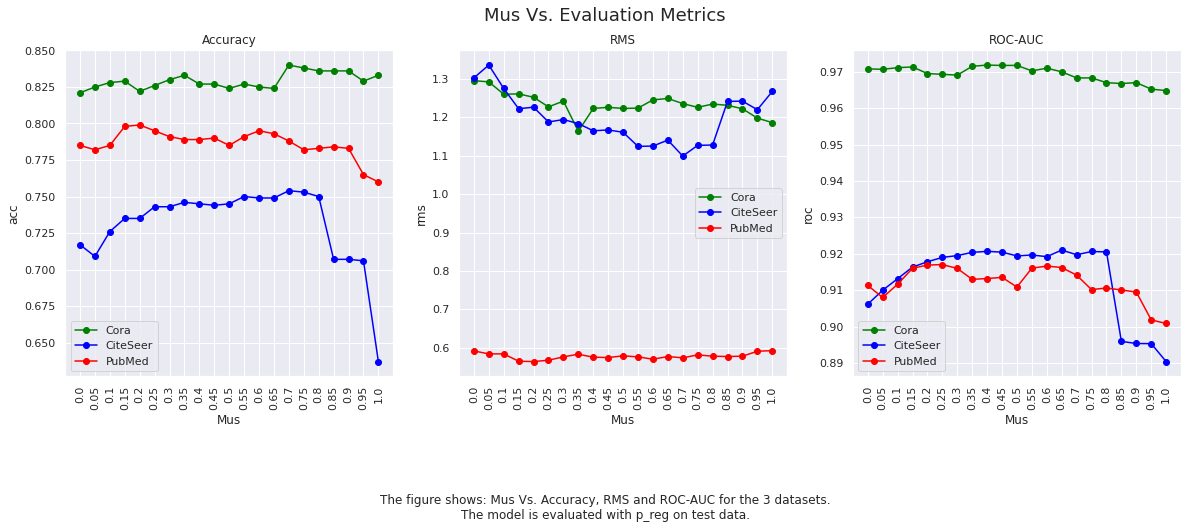

In [33]:
# report vis
report_vis(Results, params, params_tag, reg_loss)

In [34]:
# report stats
report_stats(Results, params, params_tag)

========= Cora:
    acc best Mus on test: 0.7
    rms best Mus on test: 0.35
    roc best Mus on test: 0.4
========= CiteSeer:
    acc best Mus on test: 0.7
    rms best Mus on test: 0.7
    roc best Mus on test: 0.65
========= PubMed:
    acc best Mus on test: 0.2
    rms best Mus on test: 0.2
    roc best Mus on test: 0.25


## Fixed A, B and Mu with different Seeds
L03 P02 Q02


In [35]:
# set parameters
clear()
reg_loss = 'p_reg'
A        = 20
B        = 30
mu       = 0.5
seeds    = np.arange(10)


In [36]:
# train and evaluate 
Results, params, params_tag, reg_loss = evaluation(A = A, B = B, seeds = seeds, mu=mu, reg_loss=reg_loss)

Training with p_reg with different "Seeds":
Cora:
0%: seed= 0, train_loss: 0.4564, best_epoch: 177, break_epoch: -1
    Test_acc: 0.7960
50%: seed= 5, train_loss: 0.4973, best_epoch: 154, break_epoch: -1
    Test_acc: 0.8117
CiteSeer:
0%: seed= 0, train_loss: 0.6240, best_epoch: 159, break_epoch: -1
    Test_acc: 0.7103
50%: seed= 5, train_loss: 0.8950, best_epoch: 91, break_epoch: -1
    Test_acc: 0.7040
PubMed:
0%: seed= 0, train_loss: 0.7260, best_epoch: 45, break_epoch: -1
    Test_acc: 0.7778
50%: seed= 5, train_loss: 0.4786, best_epoch: 91, break_epoch: -1
    Test_acc: 0.7684


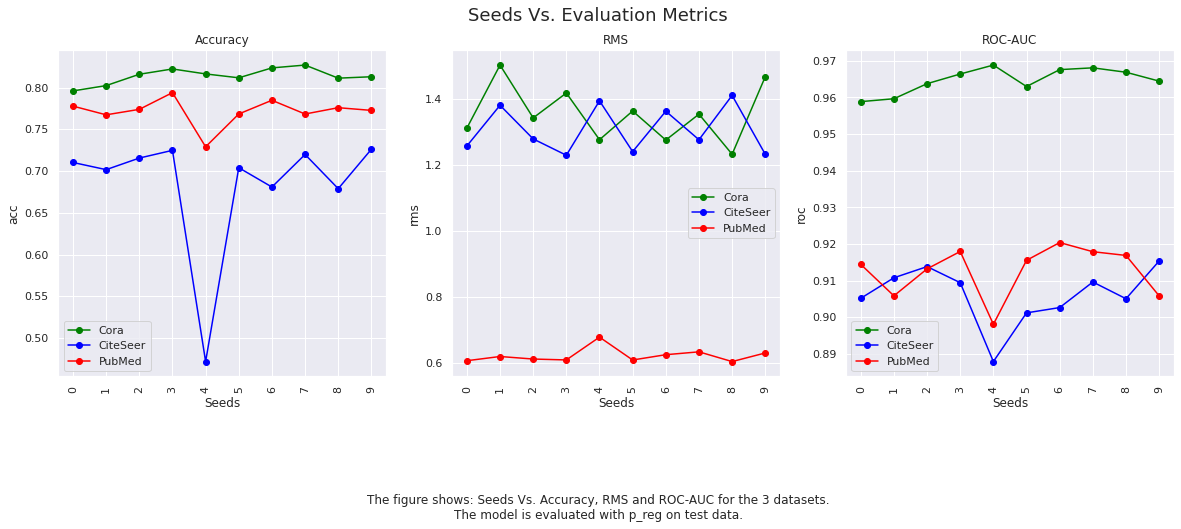

In [37]:
# report vis
report_vis(Results, params, params_tag, reg_loss)

In [38]:
# report stats
report_stats(Results, params, params_tag)

========= Cora:
    acc best Seeds on test: 7
    rms best Seeds on test: 8
    roc best Seeds on test: 4
========= CiteSeer:
    acc best Seeds on test: 9
    rms best Seeds on test: 3
    roc best Seeds on test: 9
========= PubMed:
    acc best Seeds on test: 3
    rms best Seeds on test: 8
    roc best Seeds on test: 6


## Fixed Seed and Mu with different As and Bs
L03 P02 Q03


In [39]:
# set parameters
clear()
reg_loss = 'p_reg'
seed = 3
mu = 0.5
As = [20, 30, 40, 50, 60] 
Bs = np.array(As) + 10

In [40]:
# train an evaluate
Results, params, params_tag, reg_loss = evaluation(As = As, Bs = Bs, mu=mu, seed = seed, reg_loss = reg_loss)

Training with p_reg with different "Number Training Nodes":
Cora:
0%: A,B= (20,30), train_loss: 0.4618, best_epoch: 189, break_epoch: -1
    Test_acc: 0.8223
40%: A,B= (40,50), train_loss: 0.5075, best_epoch: 190, break_epoch: -1
    Test_acc: 0.8513
80%: A,B= (60,70), train_loss: 0.6020, best_epoch: 163, break_epoch: -1
    Test_acc: 0.8426
CiteSeer:
0%: A,B= (20,30), train_loss: 0.5822, best_epoch: 147, break_epoch: -1
    Test_acc: 0.7248
40%: A,B= (40,50), train_loss: 0.7454, best_epoch: 144, break_epoch: -1
    Test_acc: 0.7266
80%: A,B= (60,70), train_loss: 0.6566, best_epoch: 196, break_epoch: -1
    Test_acc: 0.7358
PubMed:
0%: A,B= (20,30), train_loss: 0.3402, best_epoch: 199, break_epoch: -1
    Test_acc: 0.7939
40%: A,B= (40,50), train_loss: 0.5030, best_epoch: 99, break_epoch: -1
    Test_acc: 0.8149
80%: A,B= (60,70), train_loss: 0.4418, best_epoch: 145, break_epoch: -1
    Test_acc: 0.8141


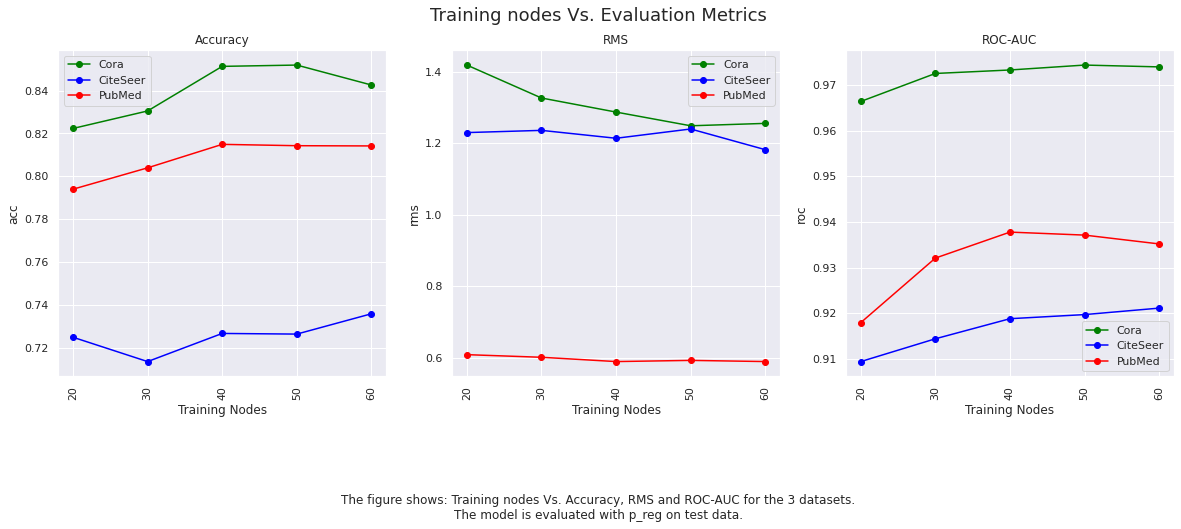

In [41]:
# report vis
report_vis(Results, params, params_tag, reg_loss)

In [42]:
# report stats
report_stats(Results, params, params_tag)

========= Cora:
    acc best Training Nodes on test: 50
    rms best Training Nodes on test: 50
    roc best Training Nodes on test: 50
========= CiteSeer:
    acc best Training Nodes on test: 60
    rms best Training Nodes on test: 60
    roc best Training Nodes on test: 60
========= PubMed:
    acc best Training Nodes on test: 40
    rms best Training Nodes on test: 40
    roc best Training Nodes on test: 40


# Aanalysis 03 (Mu vs Losses)
* Propagation Regularization
* Laplacian Regularization 
* Confidence Penalization 
* Label Smoothing

## P-Reg
Fixed A, B and Seed with different Mus

In [43]:
# set parameters
clear()
reg_loss ='p_reg'
A = 20
B = 30
seed = 0
mus = np.linspace(0,1,21)

In [44]:
# train and evaluate 
Results, params, params_tag, reg_loss = evaluation(A = A, B = B, seed = seed, mus= mus, reg_loss = reg_loss)

Training with p_reg with different "Mus":
Cora:
0%: mu= 0.0000, train_loss: 0.2080, best_epoch: 127, break_epoch: -1
    Test_acc: 0.8066
23%: mu= 0.2500, train_loss: 0.3746, best_epoch: 159, break_epoch: -1
    Test_acc: 0.8062
47%: mu= 0.5000, train_loss: 0.4564, best_epoch: 177, break_epoch: -1
    Test_acc: 0.7960
71%: mu= 0.7500, train_loss: 0.5232, best_epoch: 192, break_epoch: -1
    Test_acc: 0.7918
95%: mu= 1.0000, train_loss: 0.6965, best_epoch: 160, break_epoch: -1
    Test_acc: 0.6811
CiteSeer:
0%: mu= 0.0000, train_loss: 0.6003, best_epoch: 61, break_epoch: -1
    Test_acc: 0.6888
23%: mu= 0.2500, train_loss: 0.8271, best_epoch: 71, break_epoch: -1
    Test_acc: 0.6842
47%: mu= 0.5000, train_loss: 0.6240, best_epoch: 159, break_epoch: -1
    Test_acc: 0.7103
71%: mu= 0.7500, train_loss: 0.9773, best_epoch: 106, break_epoch: -1
    Test_acc: 0.3162
95%: mu= 1.0000, train_loss: 0.8581, best_epoch: 139, break_epoch: -1
    Test_acc: 0.2686
PubMed:
0%: mu= 0.0000, train_loss: 

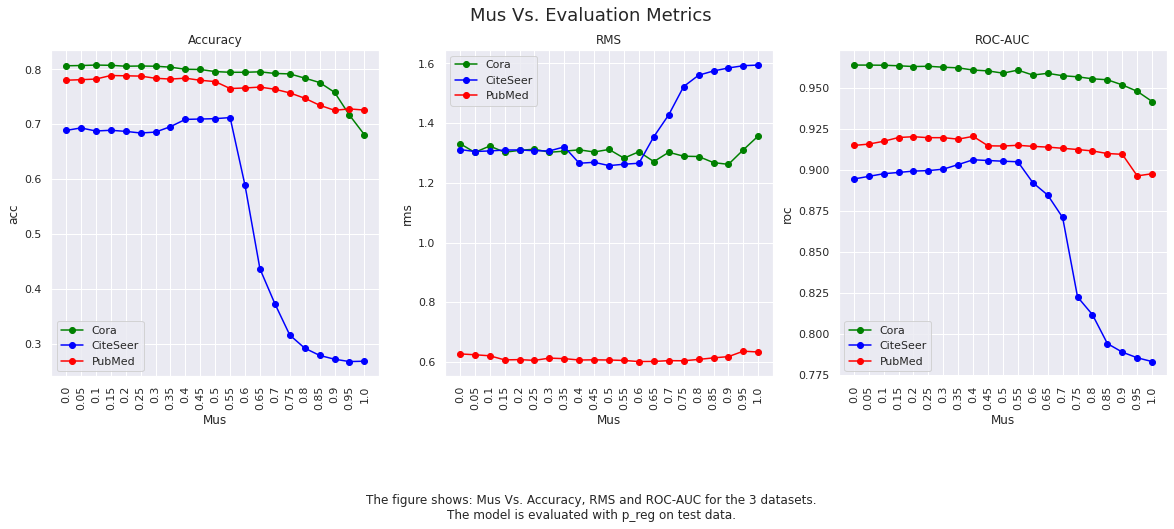

In [45]:
# report vis
report_vis(Results, params, params_tag, reg_loss)

In [46]:
# report stats
report_stats(Results, params, params_tag)

========= Cora:
    acc best Mus on test: 0.1
    rms best Mus on test: 0.9
    roc best Mus on test: 0.0
========= CiteSeer:
    acc best Mus on test: 0.55
    rms best Mus on test: 0.5
    roc best Mus on test: 0.4
========= PubMed:
    acc best Mus on test: 0.15
    rms best Mus on test: 0.6
    roc best Mus on test: 0.4


## Lap-Reg
Fixed A, B and Seed with different Mus

In [47]:
# set parameters
clear()
reg_loss ='lap_reg'
A = 20
B = 30
seed = 0
mus = np.linspace(0,1,21)


In [48]:
# train and evaluate 
Results, params, params_tag, reg_loss = evaluation(A = 20, B=30, seed = seed, mus=mus, reg_loss = reg_loss)

Training with lap_reg with different "Mus":
Cora:
0%: mu= 0.0000, train_loss: 0.2080, best_epoch: 127, break_epoch: -1
    Test_acc: 0.8066
23%: mu= 0.2500, train_loss: 0.8441, best_epoch: 65, break_epoch: -1
    Test_acc: 0.7316
47%: mu= 0.5000, train_loss: 0.9250, best_epoch: 100, break_epoch: -1
    Test_acc: 0.6671
71%: mu= 0.7500, train_loss: 1.1206, best_epoch: 60, break_epoch: -1
    Test_acc: 0.6408
95%: mu= 1.0000, train_loss: 1.0613, best_epoch: 120, break_epoch: -1
    Test_acc: 0.5937
CiteSeer:
0%: mu= 0.0000, train_loss: 0.6003, best_epoch: 61, break_epoch: -1
    Test_acc: 0.6888
23%: mu= 0.2500, train_loss: 1.0027, best_epoch: 42, break_epoch: -1
    Test_acc: 0.6759
47%: mu= 0.5000, train_loss: 1.0352, best_epoch: 45, break_epoch: -1
    Test_acc: 0.6627
71%: mu= 0.7500, train_loss: 1.1082, best_epoch: 44, break_epoch: -1
    Test_acc: 0.6508
95%: mu= 1.0000, train_loss: 1.1540, best_epoch: 43, break_epoch: -1
    Test_acc: 0.6178
PubMed:
0%: mu= 0.0000, train_loss: 0.2

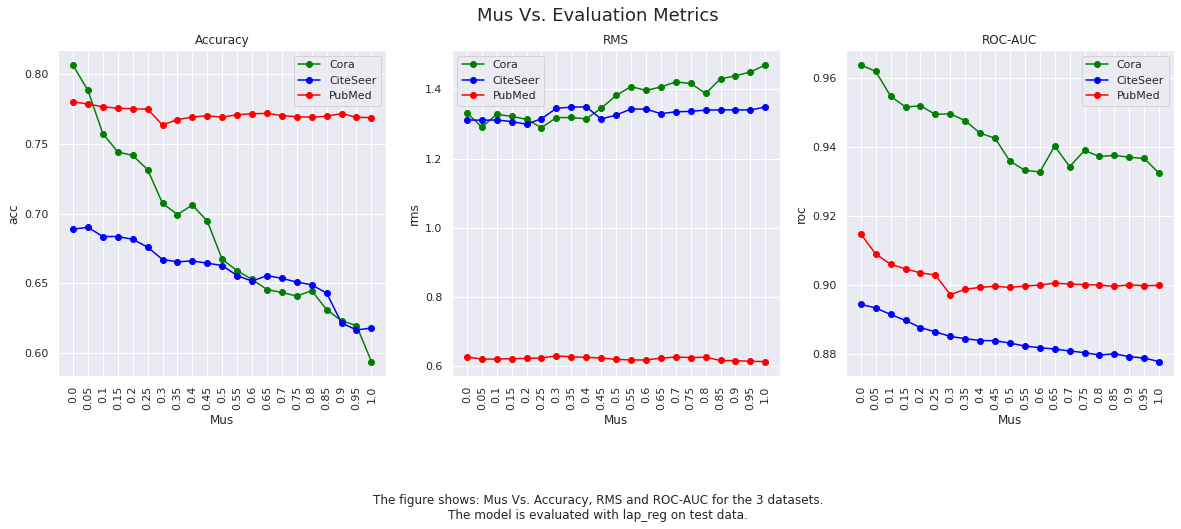

In [49]:
# report vis
report_vis(Results, params, params_tag, reg_loss)

In [50]:
# report stats
report_stats(Results, params, params_tag)

========= Cora:
    acc best Mus on test: 0.0
    rms best Mus on test: 0.25
    roc best Mus on test: 0.0
========= CiteSeer:
    acc best Mus on test: 0.05
    rms best Mus on test: 0.2
    roc best Mus on test: 0.0
========= PubMed:
    acc best Mus on test: 0.0
    rms best Mus on test: 1.0
    roc best Mus on test: 0.0


## CP-Reg 
Fixed A, B and Seed with different Mus. 

In [51]:
# set parameters
clear()
reg_loss ='cp_reg'
A = 20
B = 30
seed = 0
mus = np.linspace(0,1,21)

In [52]:
# train and evaluate 
Results, params, params_tag, reg_loss = evaluation(A=A, B=B,seed = seed, mus=mus, reg_loss = reg_loss)

Training with cp_reg with different "Mus":
Cora:
0%: mu= 0.0000, train_loss: 0.2080, best_epoch: 127, break_epoch: -1
    Test_acc: 0.8066
23%: mu= 0.2500, train_loss: 0.3506, best_epoch: 141, break_epoch: -1
    Test_acc: 0.8053
47%: mu= 0.5000, train_loss: 0.3735, best_epoch: 177, break_epoch: -1
    Test_acc: 0.8049
71%: mu= 0.7500, train_loss: 0.4456, best_epoch: 180, break_epoch: -1
    Test_acc: 0.8007
95%: mu= 1.0000, train_loss: 0.5239, best_epoch: 193, break_epoch: -1
    Test_acc: 0.7260
CiteSeer:
0%: mu= 0.0000, train_loss: 0.6003, best_epoch: 61, break_epoch: -1
    Test_acc: 0.6888
23%: mu= 0.2500, train_loss: 0.6566, best_epoch: 93, break_epoch: -1
    Test_acc: 0.6974
47%: mu= 0.5000, train_loss: 0.5053, best_epoch: 192, break_epoch: -1
    Test_acc: 0.7080
71%: mu= 0.7500, train_loss: 0.6193, best_epoch: 184, break_epoch: -1
    Test_acc: 0.3826
95%: mu= 1.0000, train_loss: 0.6635, best_epoch: 197, break_epoch: -1
    Test_acc: 0.3039
PubMed:
0%: mu= 0.0000, train_loss:

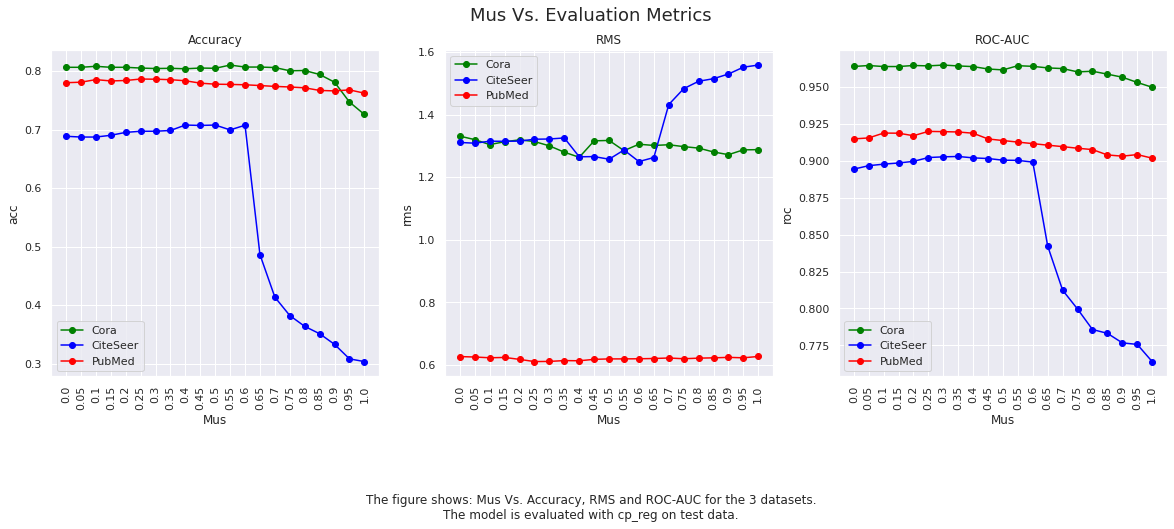

In [53]:
# report vis
report_vis(Results, params, params_tag, reg_loss)

In [54]:
# report stats
report_stats(Results, params, params_tag)

========= Cora:
    acc best Mus on test: 0.55
    rms best Mus on test: 0.4
    roc best Mus on test: 0.3
========= CiteSeer:
    acc best Mus on test: 0.4
    rms best Mus on test: 0.6
    roc best Mus on test: 0.35
========= PubMed:
    acc best Mus on test: 0.25
    rms best Mus on test: 0.25
    roc best Mus on test: 0.25


## Label Smoothing
Fixed A, B and Seed with different Mus.

In [55]:
# set parameters
clear()
reg_loss='ls_reg'
mus = np.linspace(0,1,21)[0:-1]

In [56]:
# train and evaluate 
Results, params, params_tag, reg_loss = evaluation(mus=mus, reg_loss=reg_loss)

Training with ls_reg with different "Mus":
Cora:
0%: mu= 0.0000, train_loss: 0.6252, best_epoch: 39, break_epoch: -1
    Test_acc: 0.8210
25%: mu= 0.2500, train_loss: 1.2565, best_epoch: 39, break_epoch: -1
    Test_acc: 0.8180
50%: mu= 0.5000, train_loss: 1.6458, best_epoch: 129, break_epoch: -1
    Test_acc: 0.8150
75%: mu= 0.7500, train_loss: 1.9287, best_epoch: 185, break_epoch: -1
    Test_acc: 0.7780
CiteSeer:
0%: mu= 0.0000, train_loss: 0.2369, best_epoch: 196, break_epoch: -1
    Test_acc: 0.7170
25%: mu= 0.2500, train_loss: 1.0818, best_epoch: 186, break_epoch: -1
    Test_acc: 0.7230
50%: mu= 0.5000, train_loss: 1.5710, best_epoch: 115, break_epoch: -1
    Test_acc: 0.7300
75%: mu= 0.7500, train_loss: 1.7902, best_epoch: 10, break_epoch: -1
    Test_acc: 0.6040
PubMed:
0%: mu= 0.0000, train_loss: 0.2199, best_epoch: 54, break_epoch: -1
    Test_acc: 0.7850
25%: mu= 0.2500, train_loss: 0.8089, best_epoch: 44, break_epoch: -1
    Test_acc: 0.7930
50%: mu= 0.5000, train_loss: 1.

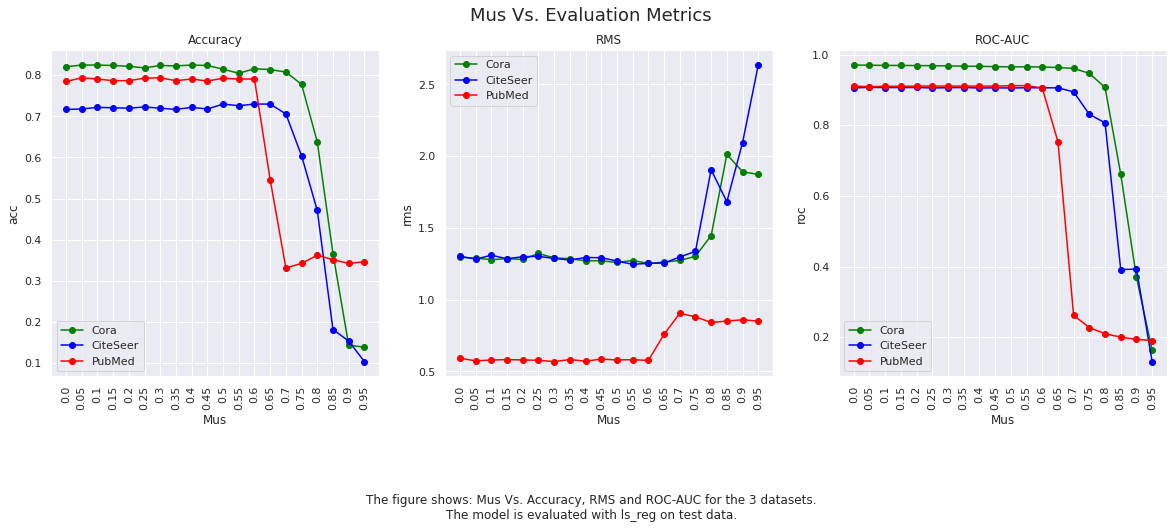

In [57]:
# report vis
report_vis(Results, params, params_tag, reg_loss)

In [58]:
# report stats
report_stats(Results, params, params_tag)

========= Cora:
    acc best Mus on test: 0.05
    rms best Mus on test: 0.6
    roc best Mus on test: 0.0
========= CiteSeer:
    acc best Mus on test: 0.5
    rms best Mus on test: 0.55
    roc best Mus on test: 0.05
========= PubMed:
    acc best Mus on test: 0.05
    rms best Mus on test: 0.3
    roc best Mus on test: 0.55


# Figure 3

## TSNE Functions

In [62]:
def TSNE_Runs(dataset_Name, reg_mu = 0.5):
    # init storages  
    Results_lst = []
    subtitles = []

    # init 1st run
    """ set sub_title """
    subtitles.append("GCN")

    """ evaluate """ 
    Results, _ , _ , _ = evaluation(
                                datasets = [dataset_Name], 
                                mu = 0, 
                                seed = 3, 
                                reg_loss = 'no_reg', 
                                verbose = False
                            )
    Results_lst.append(Results)


    # init 2nd run
    """ set sub_title """
    subtitles.append(f"GCN + P-reg (µ = {reg_mu})")

    """ evaluate """ 
    Results, _ , _ , _ = evaluation(datasets = [dataset_Name], 
                                mu = reg_mu, 
                                seed = 3, 
                                reg_loss = 'p_reg', 
                                p_reg_phi = 'cross_entropy',
                                verbose = False 
                            )
    Results_lst.append(Results)

    # init 3rd run 
    """ set sub_title """
    subtitles.append(f"GCN + Laplacian-reg (µ = {reg_mu})")

    """ evaluate """
    Results, _ , _ , _ = evaluation(datasets = [dataset_Name], 
                                mu = reg_mu, 
                                seed = 3, 
                                reg_loss = 'lap_reg', 
                                verbose = False 
                            )
    Results_lst.append(Results)

    return Results_lst, subtitles, dataset_Name

In [60]:
# TSNE_Report Function to plot figure 03 from the paper
def TSNE_Report(Results_lst, subtitles, dataset_Name):    
    # check input 
    assert len(Results_lst) == 3, "Results_lst should have 3 values"
    assert len(subtitles) == 3, "subtitles should have 3 values"
    assert dataset_Name in ['Cora', 'CiteSeer', 'PubMed'], "check dataset_Name"

    # from list to dict
    Results_lst = [Results_lst[x] for x in range(len(Results_lst))]
    
    # load dataset
    dataset = load_dataset(dataset_Name)

    # Set figure params
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    plt.suptitle(f"{dataset_Name} - TSNE visualization of embeddings on Test data", fontsize=18);
    for i, Results in enumerate(Results_lst): 
        # get Z, test_mask 
        Z = Results[f'{dataset_Name}_Z'][0]
        test_mask = Results[f'{dataset_Name}_test_mask'][0]

        # TSNE Embedding
        transform = TSNE  # or PCA
        trans = transform(n_components=2, init='pca', learning_rate='auto')
        X_reduced = trans.fit_transform(Z[test_mask,:].detach().cpu().numpy())

        # Plot
        axs[i].scatter(
            X_reduced[:, 0],
            X_reduced[:, 1],
            c = dataset[0].y[test_mask],
            cmap = "jet",
            alpha = 0.7,
        )
        axs[i].set(
            xlabel = "$X_1$",
            ylabel = "$X_2$",
            title = subtitles[i]
        )
        
    caption =   f"The t-SNE visualization of GCN outputs " \
                f"on the {dataset_Name} test dataset (best viewed in color)." 
    plt.figtext(0.5, -0.2, caption, wrap=True, horizontalalignment='center', fontsize=12)
    plt.show()

#### CiteSeer

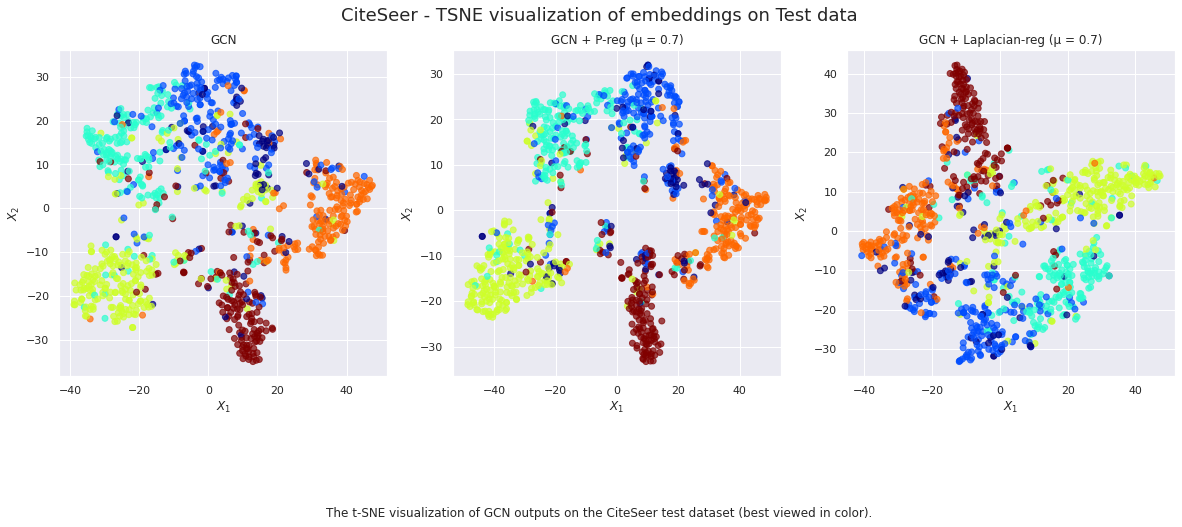

In [67]:
TSNE_Report(*TSNE_Runs('CiteSeer', reg_mu = 0.7))

#### Cora

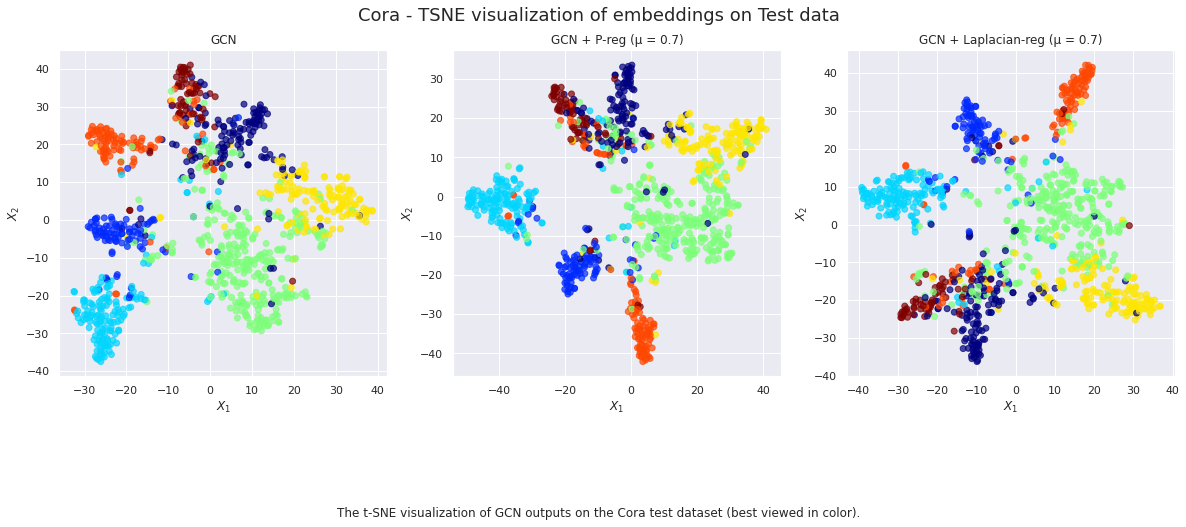

In [68]:
TSNE_Report(*TSNE_Runs('Cora', reg_mu = 0.7))

#### PubMed

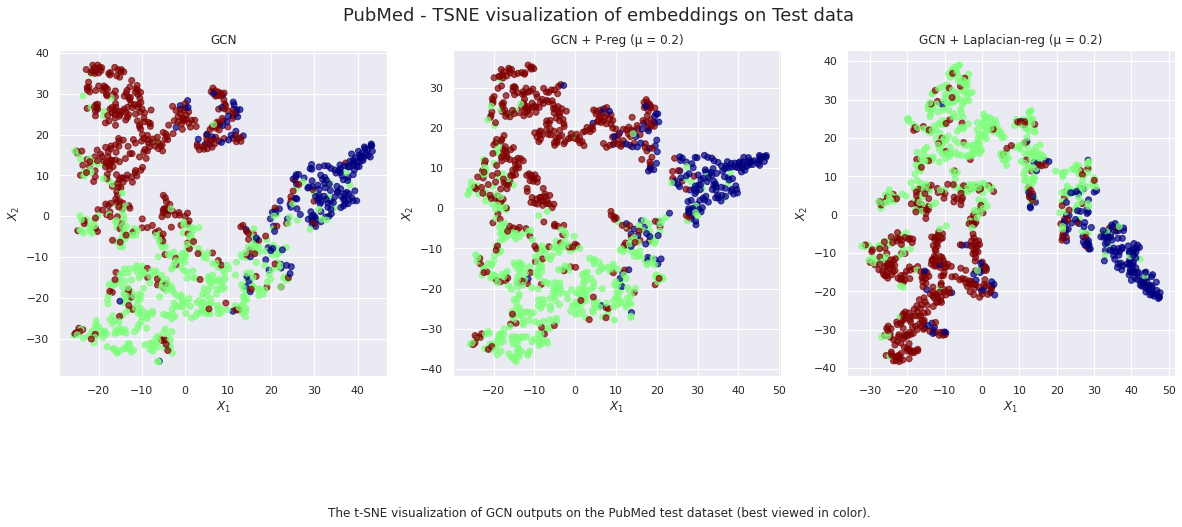

In [69]:
TSNE_Report(*TSNE_Runs('PubMed', reg_mu = 0.2))

# Table 1


## Table Function

In [128]:
def Table(  A = None, # int 
            B = None, # int 
            seeds = None, # float list 
            reg_loss = None, # str: 'p_reg', 'lap_reg', 'cp_reg', 'no_reg' 
            p_reg_phi = None, # str: 'cross_entropy', 'squared_error', 'kl_divergence'
            model_name = 'GCN', # str: 'GCN','GAT','MLP'
            dataset_mus = {'Cora': None, 'CiteSeer': None, 'PubMed': None}, # dict: dataset_Name:str -> mu:folat
            epochs = 200, # int
            patience = 100, # int 
            verbose = True, # bolean
        ):

    # check reg_loss input arg.
    if reg_loss is not None:
        assert reg_loss in ['p_reg', 'lap_reg', 'cp_reg', 'ls_reg', 'no_reg'], "check reg_losse arg."    
        if reg_loss == 'no_reg':
            for dataset_Name in dataset_mus.keys():
                dataset_mus[dataset_Name] == 0, "mu should be 0"
            
 
    # check p_reg_phi input arg.
    if p_reg_phi is not None:
        assert p_reg_phi in ['cross_entropy', 'squared_error', 'kl_divergence'], 'check p_reg_phi arg.'
        assert reg_loss == 'p_reg' , "reg_loss should be p_reg'"


    # Start Training
    if verbose: print(f'Training with {reg_loss} with different "Seeds":')

    # evaluation Storage
    Results = {}
    
    # loop over datasets
    for dataset_name in dataset_mus.keys(): 
        # define dataset
        if verbose: print(f'========================= {dataset_name}:')
        dataset = load_dataset(dataset_name)
        
        # define data
        data = dataset[0]
        data = data.to(device)

        # define mu
        mu = dataset_mus[dataset_name]
        print(f'µ = {mu}')

        # calc number of classes
        num_classes = dataset.num_classes
        
        # calc A_hat as it's training invariant 
        if reg_loss == 'p_reg':
            A_hat, A_hat_mask, N = A_hat_computations(data)
            p_reg_dict = {'A_hat': A_hat, 
                          'A_hat_mask': A_hat_mask, 
                          'N': N, 
                          'phi': 'cross_entropy' if p_reg_phi is None else p_reg_phi}  
        else: 
            p_reg_dict = None

        # define test evaluation metrices
        Results[dataset_name+'_acc' ] = []

        # loop over params
        for i in range(len(seeds)):
            # define seed
            seed = seeds[i]
            torch.manual_seed(seed)

            # calc the split
            if (A is not None) & (B is not None):
                train_mask, val_mask, test_mask = random_split(dataset, A, B, seed)
                train_mask = train_mask.to(device)
                val_mask = val_mask.to(device)
                test_mask = test_mask.to(device)
                assert sum(train_mask)  == num_classes*A
                assert sum(val_mask)  == num_classes*B
            else:
                train_mask, val_mask, test_mask = data.train_mask, data.val_mask, data.test_mask

            # define MOC
            if model_name == 'GCN':
                model = GCN(dataset, hidden_channels=64, seed = seed).to(device) # 16 , 64 
            elif model_name == 'GAT':
                model = GAT(dataset, hidden_channels=16, seed = seed).to(device) # 8 , 16
            elif model_name == 'MLP':
                model = MLP(dataset, hidden_channels=64, seed = seed).to(device) # 16 , 64       
            else: 
                raise NotImplementedError('Only GCA, GAT and MLP models are supported')
            optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
            criterion = torch.nn.CrossEntropyLoss()

            # loop over epochs
            Val_Acc, Train_Loss, Epoch, Break_Epoch  = -np.inf, -np.inf, -1, -1
            for epoch in range(epochs):
                # train
                train_loss, _ = train(model, optimizer, criterion, data, train_mask, mu, reg_loss, p_reg_dict, num_classes)   
                # test
                with torch.no_grad():
                    _, _, val_acc, _, _, _ = test(model, data, val_mask, criterion, mu, reg_loss, p_reg_dict, num_classes)

                    if val_acc > Val_Acc: 
                        _, _, test_acc, _, _, _ = test(model, data, test_mask, criterion, mu, reg_loss, p_reg_dict, num_classes)
                        Epoch, Train_Loss, Val_Acc, Test_Acc = epoch, train_loss , val_acc, test_acc
                        wait = 0
                    else:
                        wait += 1
                    
                    if wait > patience: 
                        Break_Epoch = epoch
                        break 

            # save test metrices, loss and embadding
            Results[dataset_name+'_acc' ].append(Test_Acc)
            
            # Print 
            condition = ((verbose) & (i % 2 == 0)) if (len(seeds) < 10) else ((verbose) & (i % 5 == 0))
            precent = int(i/len(seeds)*100)
            if condition:
                print(f'{precent}%: seed= {seed}, train_loss: {Train_Loss:.4f}, best_epoch: {Epoch}, break_epoch: {Break_Epoch}')
                print(f'    Test_acc: {Test_Acc:.4f}')


    return Results

## GCN

#### Vanilla

In [129]:
# set parameters 
A        = 20
B        = 30
seeds    = np.arange(20)
model_name = 'GCN'
reg_loss = 'no_reg'
dataset_mus = {'Cora': 0, 'CiteSeer':0, 'PubMed':0} # No reg 

In [130]:
# train and evaluate 
Results = Table(A = A, B = B, seeds = seeds, 
                model_name=model_name, 
                reg_loss=reg_loss, 
                dataset_mus= dataset_mus,
                )

Training with no_reg with different "Seeds":
========================= Cora:
µ = 0
0%: seed= 0, train_loss: 0.2080, best_epoch: 127, break_epoch: -1
    Test_acc: 0.8066
20%: seed= 5, train_loss: 0.1793, best_epoch: 159, break_epoch: -1
    Test_acc: 0.8142
40%: seed= 10, train_loss: 0.2454, best_epoch: 116, break_epoch: -1
    Test_acc: 0.8117
60%: seed= 15, train_loss: 0.3853, best_epoch: 65, break_epoch: 166
    Test_acc: 0.8223
80%: seed= 20, train_loss: 0.2141, best_epoch: 135, break_epoch: -1
    Test_acc: 0.8036
========================= CiteSeer:
µ = 0
0%: seed= 0, train_loss: 0.6003, best_epoch: 61, break_epoch: 162
    Test_acc: 0.6888
20%: seed= 5, train_loss: 0.4858, best_epoch: 71, break_epoch: 172
    Test_acc: 0.7040
40%: seed= 10, train_loss: 0.8814, best_epoch: 39, break_epoch: 140
    Test_acc: 0.7004
60%: seed= 15, train_loss: 0.8274, best_epoch: 41, break_epoch: 142
    Test_acc: 0.6977
80%: seed= 20, train_loss: 0.2190, best_epoch: 171, break_epoch: -1
    Test_acc

In [131]:
for dataset_Name in ['Cora', 'CiteSeer', 'PubMed']:
    mean= np.mean(Results[f'{dataset_Name}_acc'])
    std = np.std(Results[f'{dataset_Name}_acc'])
    print(f'{dataset_Name}: {np.round(mean,3)} ± {np.round(std,3)}')   

# 64
# Cora: 0.816 ± 0.01
# CiteSeer: 0.696 ± 0.01
# PubMed: 0.781 ± 0.01

Cora: 0.815 ± 0.008
CiteSeer: 0.697 ± 0.009
PubMed: 0.78 ± 0.009


#### Label Smoothing

In [132]:
# set parameters 
A        = 20
B        = 30
seeds    = np.arange(20)
model_name = 'GCN'
reg_loss = 'ls_reg'
dataset_mus = {'Cora': 0.05, 'CiteSeer':0.5, 'PubMed':0.05} # See Analysis 03 

In [133]:
# train and evaluate 
Results = Table(A = A, B = B, seeds = seeds, 
                model_name=model_name, 
                reg_loss=reg_loss, 
                dataset_mus= dataset_mus,
                )

Training with ls_reg with different "Seeds":
========================= Cora:
µ = 0.05
0%: seed= 0, train_loss: 0.4377, best_epoch: 154, break_epoch: -1
    Test_acc: 0.8066
20%: seed= 5, train_loss: 0.4416, best_epoch: 133, break_epoch: -1
    Test_acc: 0.8168
40%: seed= 10, train_loss: 0.6365, best_epoch: 61, break_epoch: 162
    Test_acc: 0.8117
60%: seed= 15, train_loss: 0.6420, best_epoch: 52, break_epoch: 153
    Test_acc: 0.8210
80%: seed= 20, train_loss: 0.4463, best_epoch: 133, break_epoch: -1
    Test_acc: 0.8075
========================= CiteSeer:
µ = 0.5
0%: seed= 0, train_loss: 1.5776, best_epoch: 95, break_epoch: 196
    Test_acc: 0.6984
20%: seed= 5, train_loss: 1.5606, best_epoch: 138, break_epoch: -1
    Test_acc: 0.7047
40%: seed= 10, train_loss: 1.6784, best_epoch: 29, break_epoch: 130
    Test_acc: 0.7043
60%: seed= 15, train_loss: 1.5672, best_epoch: 116, break_epoch: -1
    Test_acc: 0.7033
80%: seed= 20, train_loss: 1.5640, best_epoch: 131, break_epoch: -1
    Tes

In [134]:
for dataset_Name in ['Cora', 'CiteSeer', 'PubMed']:
    mean= np.mean(Results[f'{dataset_Name}_acc'])
    std = np.std(Results[f'{dataset_Name}_acc'])
    print(f'{dataset_Name}: {np.round(mean,3)} ± {np.round(std,3)}')   

# 64
# Cora: 0.815 ± 0.01
# CiteSeer: 0.7 ± 0.01
# PubMed: 0.783 ± 0.01

Cora: 0.816 ± 0.007
CiteSeer: 0.702 ± 0.009
PubMed: 0.782 ± 0.008


#### Confidence Penalty

In [135]:
# set parameters 
A        = 20
B        = 30
seeds    = np.arange(20)
model_name = 'GCN'
reg_loss = 'cp_reg'
dataset_mus = {'Cora': 0.55, 'CiteSeer':0.4, 'PubMed':0.25} # See Analysis 03 

In [136]:
# train and evaluate 
Results = Table(A = A, B = B, seeds = seeds, 
                model_name=model_name, 
                reg_loss=reg_loss, 
                dataset_mus= dataset_mus,
                )

Training with cp_reg with different "Seeds":
========================= Cora:
µ = 0.55
0%: seed= 0, train_loss: 0.5040, best_epoch: 118, break_epoch: -1
    Test_acc: 0.8104
20%: seed= 5, train_loss: 0.4179, best_epoch: 155, break_epoch: -1
    Test_acc: 0.8138
40%: seed= 10, train_loss: 0.6827, best_epoch: 85, break_epoch: 186
    Test_acc: 0.8096
60%: seed= 15, train_loss: 0.4905, best_epoch: 125, break_epoch: -1
    Test_acc: 0.8164
80%: seed= 20, train_loss: 0.4503, best_epoch: 148, break_epoch: -1
    Test_acc: 0.8189
========================= CiteSeer:
µ = 0.4
0%: seed= 0, train_loss: 0.9504, best_epoch: 72, break_epoch: 173
    Test_acc: 0.6885
20%: seed= 5, train_loss: 0.8320, best_epoch: 80, break_epoch: 181
    Test_acc: 0.7047
40%: seed= 10, train_loss: 1.2734, best_epoch: 49, break_epoch: 150
    Test_acc: 0.6905
60%: seed= 15, train_loss: 0.5854, best_epoch: 121, break_epoch: -1
    Test_acc: 0.7063
80%: seed= 20, train_loss: 0.4567, best_epoch: 186, break_epoch: -1
    Tes

In [137]:
for dataset_Name in ['Cora', 'CiteSeer', 'PubMed']:
    mean= np.mean(Results[f'{dataset_Name}_acc'])
    std = np.std(Results[f'{dataset_Name}_acc'])
    print(f'{dataset_Name}: {np.round(mean,3)} ± {np.round(std,3)}')   

# 64
# Cora: 0.813 ± 0.01
# CiteSeer: 0.704 ± 0.02
# PubMed: 0.784 ± 0.01

Cora: 0.813 ± 0.009
CiteSeer: 0.707 ± 0.016
PubMed: 0.781 ± 0.012


#### Laplacian Regularization

In [138]:
# set parameters 
A        = 20
B        = 30
seeds    = np.arange(20)
model_name = 'GCN'
reg_loss = 'lap_reg'
dataset_mus = {'Cora': 0, 'CiteSeer':0.05, 'PubMed':0} # See Analysis 03 

In [139]:
# train and evaluate 
Results = Table(A = A, B = B, seeds = seeds, 
                model_name=model_name, 
                reg_loss=reg_loss, 
                dataset_mus= dataset_mus,
                )

Training with lap_reg with different "Seeds":
========================= Cora:
µ = 0
0%: seed= 0, train_loss: 0.2080, best_epoch: 127, break_epoch: -1
    Test_acc: 0.8066
20%: seed= 5, train_loss: 0.1793, best_epoch: 159, break_epoch: -1
    Test_acc: 0.8142
40%: seed= 10, train_loss: 0.2454, best_epoch: 116, break_epoch: -1
    Test_acc: 0.8117
60%: seed= 15, train_loss: 0.3853, best_epoch: 65, break_epoch: 166
    Test_acc: 0.8223
80%: seed= 20, train_loss: 0.2141, best_epoch: 135, break_epoch: -1
    Test_acc: 0.8036
========================= CiteSeer:
µ = 0.05
0%: seed= 0, train_loss: 0.7335, best_epoch: 57, break_epoch: 158
    Test_acc: 0.6901
20%: seed= 5, train_loss: 0.4424, best_epoch: 103, break_epoch: -1
    Test_acc: 0.6977
40%: seed= 10, train_loss: 0.4411, best_epoch: 103, break_epoch: -1
    Test_acc: 0.6941
60%: seed= 15, train_loss: 0.8693, best_epoch: 41, break_epoch: 142
    Test_acc: 0.6961
80%: seed= 20, train_loss: 0.3862, best_epoch: 129, break_epoch: -1
    Test

In [140]:
for dataset_Name in ['Cora', 'CiteSeer', 'PubMed']:
    mean= np.mean(Results[f'{dataset_Name}_acc'])
    std = np.std(Results[f'{dataset_Name}_acc'])
    print(f'{dataset_Name}: {np.round(mean,3)} ± {np.round(std,3)}') 

# 64
# Cora: 0.816 ± 0.01
# CiteSeer: 0.693 ± 0.01
# PubMed: 0.781 ± 0.01  

Cora: 0.815 ± 0.008
CiteSeer: 0.694 ± 0.009
PubMed: 0.78 ± 0.009


#### Preg

In [141]:
# set parameters 
A        = 20
B        = 30
seeds    = np.arange(20)
model_name = 'GCN'
reg_loss = 'p_reg'
p_reg_phi = 'cross_entropy'
dataset_mus = {'Cora': 0.1, 'CiteSeer':0.4, 'PubMed':0.15} # See Analysis 03 

In [142]:
# train and evaluate 
Results = Table(A = A, B = B, seeds = seeds, 
                model_name=model_name, 
                reg_loss=reg_loss, 
                p_reg_phi= p_reg_phi,
                dataset_mus= dataset_mus,
                )

Training with p_reg with different "Seeds":
========================= Cora:
µ = 0.1
0%: seed= 0, train_loss: 0.2604, best_epoch: 179, break_epoch: -1
    Test_acc: 0.8079
20%: seed= 5, train_loss: 0.3199, best_epoch: 118, break_epoch: -1
    Test_acc: 0.8193
40%: seed= 10, train_loss: 0.4065, best_epoch: 88, break_epoch: 189
    Test_acc: 0.8176
60%: seed= 15, train_loss: 0.5139, best_epoch: 59, break_epoch: 160
    Test_acc: 0.8193
80%: seed= 20, train_loss: 0.2875, best_epoch: 136, break_epoch: -1
    Test_acc: 0.8109
========================= CiteSeer:
µ = 0.4
0%: seed= 0, train_loss: 0.5731, best_epoch: 159, break_epoch: -1
    Test_acc: 0.7090
20%: seed= 5, train_loss: 0.7227, best_epoch: 103, break_epoch: -1
    Test_acc: 0.7146
40%: seed= 10, train_loss: 1.3046, best_epoch: 49, break_epoch: 150
    Test_acc: 0.6881
60%: seed= 15, train_loss: 0.6515, best_epoch: 120, break_epoch: -1
    Test_acc: 0.7086
80%: seed= 20, train_loss: 0.5479, best_epoch: 161, break_epoch: -1
    Test_

In [143]:
for dataset_Name in ['Cora', 'CiteSeer', 'PubMed']:
    mean= np.mean(Results[f'{dataset_Name}_acc'])
    std = np.std(Results[f'{dataset_Name}_acc'])
    print(f'{dataset_Name}: {np.round(mean,3)} ± {np.round(std,3)}')   

# 64
# Cora: 0.816 ± 0.01
# CiteSeer: 0.705 ± 0.02
# PubMed: 0.783 ± 0.01

Cora: 0.817 ± 0.007
CiteSeer: 0.706 ± 0.017
PubMed: 0.781 ± 0.01


In [ ]:
# Results:

# 64 NR
# > Cora: 0.816 ± 0.01 
# CiteSeer: 0.696 ± 0.01
# PubMed: 0.781 ± 0.01

# 64 LS
# Cora: 0.815 ± 0.01
# CiteSeer: 0.7 ± 0.01
# > PubMed: 0.783 ± 0.01

# 64 CP
# Cora: 0.813 ± 0.01
# CiteSeer: 0.704 ± 0.02
# PubMed: 0.784 ± 0.01

# 64 LR
# > Cora: 0.816 ± 0.01
# CiteSeer: 0.693 ± 0.01
# PubMed: 0.781 ± 0.01  

# 64 PR
# > Cora: 0.816 ± 0.01
# > CiteSeer: 0.705 ± 0.02
# PubMed: 0.783 ± 0.01

## GAT

#### Vanilla

In [144]:
# set parameters 
A        = 20
B        = 30
seeds    = np.arange(20)
model_name = 'GAT'
reg_loss = 'no_reg'
dataset_mus = {'Cora': 0, 'CiteSeer':0, 'PubMed':0} # No reg 

In [145]:
# train and evaluate 
Results = Table(A = A, B = B, seeds = seeds, 
                model_name=model_name, 
                reg_loss=reg_loss, 
                dataset_mus= dataset_mus,
                )

Training with no_reg with different "Seeds":
========================= Cora:
µ = 0
0%: seed= 0, train_loss: 0.6059, best_epoch: 145, break_epoch: -1
    Test_acc: 0.8219
25%: seed= 5, train_loss: 0.6601, best_epoch: 62, break_epoch: 163
    Test_acc: 0.8210
50%: seed= 10, train_loss: 0.7680, best_epoch: 57, break_epoch: 158
    Test_acc: 0.8232
75%: seed= 15, train_loss: 0.7479, best_epoch: 89, break_epoch: 190
    Test_acc: 0.8380
========================= CiteSeer:
µ = 0
0%: seed= 0, train_loss: 0.8392, best_epoch: 91, break_epoch: 192
    Test_acc: 0.6951
25%: seed= 5, train_loss: 1.2130, best_epoch: 26, break_epoch: 127
    Test_acc: 0.7080
50%: seed= 10, train_loss: 0.5677, best_epoch: 169, break_epoch: -1
    Test_acc: 0.6967
75%: seed= 15, train_loss: 1.2341, best_epoch: 26, break_epoch: 127
    Test_acc: 0.6984
========================= PubMed:
µ = 0
0%: seed= 0, train_loss: 0.4607, best_epoch: 72, break_epoch: 173
    Test_acc: 0.7653
25%: seed= 5, train_loss: 0.4495, best_epo

In [146]:
for dataset_Name in ['Cora', 'CiteSeer', 'PubMed']:
    mean= np.mean(Results[f'{dataset_Name}_acc'])
    std = np.std(Results[f'{dataset_Name}_acc'])
    print(f'{dataset_Name}: {np.round(mean,3)} ± {np.round(std,3)}')   

# 64
# Cora: 0.816 ± 0.01
# CiteSeer: 0.696 ± 0.01
# PubMed: 0.781 ± 0.01

Cora: 0.826 ± 0.007
CiteSeer: 0.696 ± 0.011
PubMed: 0.768 ± 0.014


#### Label Smoothing

In [147]:
# set parameters 
A        = 20
B        = 30
seeds    = np.arange(20)
model_name = 'GAT'
reg_loss = 'ls_reg'
dataset_mus = {'Cora': 0.05, 'CiteSeer':0.5, 'PubMed':0.05} # See Analysis 03 

In [148]:
# train and evaluate 
Results = Table(A = A, B = B, seeds = seeds, 
                model_name=model_name, 
                reg_loss=reg_loss, 
                dataset_mus= dataset_mus,
                )

Training with ls_reg with different "Seeds":
========================= Cora:
µ = 0.05
0%: seed= 0, train_loss: 0.8512, best_epoch: 170, break_epoch: -1
    Test_acc: 0.8253
25%: seed= 5, train_loss: 0.7961, best_epoch: 111, break_epoch: -1
    Test_acc: 0.8244
50%: seed= 10, train_loss: 0.9053, best_epoch: 61, break_epoch: 162
    Test_acc: 0.8215
75%: seed= 15, train_loss: 0.8571, best_epoch: 88, break_epoch: 189
    Test_acc: 0.8414
========================= CiteSeer:
µ = 0.5
0%: seed= 0, train_loss: 1.6816, best_epoch: 40, break_epoch: 141
    Test_acc: 0.6878
25%: seed= 5, train_loss: 1.6595, best_epoch: 77, break_epoch: 178
    Test_acc: 0.6928
50%: seed= 10, train_loss: 1.6736, best_epoch: 156, break_epoch: -1
    Test_acc: 0.7004
75%: seed= 15, train_loss: 1.6940, best_epoch: 24, break_epoch: 125
    Test_acc: 0.6888
========================= PubMed:
µ = 0.05
0%: seed= 0, train_loss: 0.5493, best_epoch: 70, break_epoch: 171
    Test_acc: 0.7707
25%: seed= 5, train_loss: 0.5625, 

In [149]:
for dataset_Name in ['Cora', 'CiteSeer', 'PubMed']:
    mean= np.mean(Results[f'{dataset_Name}_acc'])
    std = np.std(Results[f'{dataset_Name}_acc'])
    print(f'{dataset_Name}: {np.round(mean,3)} ± {np.round(std,3)}')   

# 64
# Cora: 0.815 ± 0.01
# CiteSeer: 0.7 ± 0.01
# PubMed: 0.783 ± 0.01

Cora: 0.826 ± 0.007
CiteSeer: 0.696 ± 0.012
PubMed: 0.771 ± 0.012


#### Confidence Penalty

In [150]:
# set parameters 
A        = 20
B        = 30
seeds    = np.arange(20)
model_name = 'GAT'
reg_loss = 'cp_reg'
dataset_mus = {'Cora': 0.55, 'CiteSeer':0.4, 'PubMed':0.25} # See Analysis 03 

In [151]:
# train and evaluate 
Results = Table(A = A, B = B, seeds = seeds, 
                model_name=model_name, 
                reg_loss=reg_loss, 
                dataset_mus= dataset_mus,
                )

Training with cp_reg with different "Seeds":
========================= Cora:
µ = 0.55


ValueError: ignored

In [ ]:
for dataset_Name in ['Cora', 'CiteSeer', 'PubMed']:
    mean= np.mean(Results[f'{dataset_Name}_acc'])
    std = np.std(Results[f'{dataset_Name}_acc'])
    print(f'{dataset_Name}: {np.round(mean,3)} ± {np.round(std,3)}')   

# 64
# Cora: 0.813 ± 0.01
# CiteSeer: 0.704 ± 0.02
# PubMed: 0.784 ± 0.01

#### Laplacian Regularization

In [ ]:
# set parameters 
A        = 20
B        = 30
seeds    = np.arange(20)
model_name = 'GAT'
reg_loss = 'lap_reg'
dataset_mus = {'Cora': 0, 'CiteSeer':0.05, 'PubMed':0} # See Analysis 03 

In [ ]:
# train and evaluate 
Results = Table(A = A, B = B, seeds = seeds, 
                model_name=model_name, 
                reg_loss=reg_loss, 
                dataset_mus= dataset_mus,
                )

In [ ]:
for dataset_Name in ['Cora', 'CiteSeer', 'PubMed']:
    mean= np.mean(Results[f'{dataset_Name}_acc'])
    std = np.std(Results[f'{dataset_Name}_acc'])
    print(f'{dataset_Name}: {np.round(mean,3)} ± {np.round(std,3)}') 

# 64
# Cora: 0.816 ± 0.01
# CiteSeer: 0.693 ± 0.01
# PubMed: 0.781 ± 0.01  

#### Preg

In [ ]:
# set parameters 
A        = 20
B        = 30
seeds    = np.arange(20)
model_name = 'GAT'
reg_loss = 'p_reg'
p_reg_phi = 'cross_entropy'
dataset_mus = {'Cora': 0.1, 'CiteSeer':0.4, 'PubMed':0.15} # See Analysis 03 

In [ ]:
# train and evaluate 
Results = Table(A = A, B = B, seeds = seeds, 
                model_name=model_name, 
                reg_loss=reg_loss, 
                p_reg_phi= p_reg_phi,
                dataset_mus= dataset_mus,
                )

In [ ]:
for dataset_Name in ['Cora', 'CiteSeer', 'PubMed']:
    mean= np.mean(Results[f'{dataset_Name}_acc'])
    std = np.std(Results[f'{dataset_Name}_acc'])
    print(f'{dataset_Name}: {np.round(mean,3)} ± {np.round(std,3)}')   

# 64
# Cora: 0.816 ± 0.01
# CiteSeer: 0.705 ± 0.02
# PubMed: 0.783 ± 0.01

In [ ]:
# Results:

# 64 NR
# > Cora: 0.816 ± 0.01 
# CiteSeer: 0.696 ± 0.01
# PubMed: 0.781 ± 0.01

# 64 LS
# Cora: 0.815 ± 0.01
# CiteSeer: 0.7 ± 0.01
# > PubMed: 0.783 ± 0.01

# 64 CP
# Cora: 0.813 ± 0.01
# CiteSeer: 0.704 ± 0.02
# PubMed: 0.784 ± 0.01

# 64 LR
# > Cora: 0.816 ± 0.01
# CiteSeer: 0.693 ± 0.01
# PubMed: 0.781 ± 0.01  

# 64 PR
# > Cora: 0.816 ± 0.01
# > CiteSeer: 0.705 ± 0.02
# PubMed: 0.783 ± 0.01

## MLP

#### Vanilla

In [ ]:
# set parameters 
A        = 20
B        = 30
seeds    = np.arange(20)
model_name = 'MLP'
reg_loss = 'no_reg'
dataset_mus = {'Cora': 0, 'CiteSeer':0, 'PubMed':0} # No reg 

In [ ]:
# train and evaluate 
Results = Table(A = A, B = B, seeds = seeds, 
                model_name=model_name, 
                reg_loss=reg_loss, 
                dataset_mus= dataset_mus,
                )

Training with no_reg with different "Seeds":
========================= Cora:
µ = 0
0%: seed= 0, train_loss: 0.6059, best_epoch: 145, break_epoch: -1
    Test_acc: 0.8219
25%: seed= 5, train_loss: 0.6601, best_epoch: 62, break_epoch: 163
    Test_acc: 0.8210
50%: seed= 10, train_loss: 0.7680, best_epoch: 57, break_epoch: 158
    Test_acc: 0.8232
75%: seed= 15, train_loss: 0.7479, best_epoch: 89, break_epoch: 190
    Test_acc: 0.8380


In [ ]:
for dataset_Name in ['Cora', 'CiteSeer', 'PubMed']:
    mean= np.mean(Results[f'{dataset_Name}_acc'])
    std = np.std(Results[f'{dataset_Name}_acc'])
    print(f'{dataset_Name}: {np.round(mean,3)} ± {np.round(std,3)}')   

# 64
# Cora: 0.816 ± 0.01
# CiteSeer: 0.696 ± 0.01
# PubMed: 0.781 ± 0.01

#### Label Smoothing

In [ ]:
# set parameters 
A        = 20
B        = 30
seeds    = np.arange(20)
model_name = 'MLP'
reg_loss = 'ls_reg'
dataset_mus = {'Cora': 0.05, 'CiteSeer':0.5, 'PubMed':0.05} # See Analysis 03 

In [ ]:
# train and evaluate 
Results = Table(A = A, B = B, seeds = seeds, 
                model_name=model_name, 
                reg_loss=reg_loss, 
                dataset_mus= dataset_mus,
                )

In [ ]:
for dataset_Name in ['Cora', 'CiteSeer', 'PubMed']:
    mean= np.mean(Results[f'{dataset_Name}_acc'])
    std = np.std(Results[f'{dataset_Name}_acc'])
    print(f'{dataset_Name}: {np.round(mean,3)} ± {np.round(std,3)}')   

# 64
# Cora: 0.815 ± 0.01
# CiteSeer: 0.7 ± 0.01
# PubMed: 0.783 ± 0.01

#### Confidence Penalty

In [ ]:
# set parameters 
A        = 20
B        = 30
seeds    = np.arange(20)
model_name = 'MLP'
reg_loss = 'cp_reg'
dataset_mus = {'Cora': 0.55, 'CiteSeer':0.4, 'PubMed':0.25} # See Analysis 03 

In [ ]:
# train and evaluate 
Results = Table(A = A, B = B, seeds = seeds, 
                model_name=model_name, 
                reg_loss=reg_loss, 
                dataset_mus= dataset_mus,
                )

In [ ]:
for dataset_Name in ['Cora', 'CiteSeer', 'PubMed']:
    mean= np.mean(Results[f'{dataset_Name}_acc'])
    std = np.std(Results[f'{dataset_Name}_acc'])
    print(f'{dataset_Name}: {np.round(mean,3)} ± {np.round(std,3)}')   

# 64
# Cora: 0.813 ± 0.01
# CiteSeer: 0.704 ± 0.02
# PubMed: 0.784 ± 0.01

#### Laplacian Regularization

In [ ]:
# set parameters 
A        = 20
B        = 30
seeds    = np.arange(20)
model_name = 'MLP'
reg_loss = 'lap_reg'
dataset_mus = {'Cora': 0, 'CiteSeer':0.05, 'PubMed':0} # See Analysis 03 

In [ ]:
# train and evaluate 
Results = Table(A = A, B = B, seeds = seeds, 
                model_name=model_name, 
                reg_loss=reg_loss, 
                dataset_mus= dataset_mus,
                )

In [ ]:
for dataset_Name in ['Cora', 'CiteSeer', 'PubMed']:
    mean= np.mean(Results[f'{dataset_Name}_acc'])
    std = np.std(Results[f'{dataset_Name}_acc'])
    print(f'{dataset_Name}: {np.round(mean,3)} ± {np.round(std,3)}') 

# 64
# Cora: 0.816 ± 0.01
# CiteSeer: 0.693 ± 0.01
# PubMed: 0.781 ± 0.01  

#### Preg

In [ ]:
# set parameters 
A        = 20
B        = 30
seeds    = np.arange(20)
model_name = 'MLP'
reg_loss = 'p_reg'
p_reg_phi = 'cross_entropy'
dataset_mus = {'Cora': 0.1, 'CiteSeer':0.4, 'PubMed':0.15} # See Analysis 03 

In [ ]:
# train and evaluate 
Results = Table(A = A, B = B, seeds = seeds, 
                model_name=model_name, 
                reg_loss=reg_loss, 
                p_reg_phi= p_reg_phi,
                dataset_mus= dataset_mus,
                )

In [ ]:
for dataset_Name in ['Cora', 'CiteSeer', 'PubMed']:
    mean= np.mean(Results[f'{dataset_Name}_acc'])
    std = np.std(Results[f'{dataset_Name}_acc'])
    print(f'{dataset_Name}: {np.round(mean,3)} ± {np.round(std,3)}')   

# 64
# Cora: 0.816 ± 0.01
# CiteSeer: 0.705 ± 0.02
# PubMed: 0.783 ± 0.01

In [ ]:
# Results:

# 64 NR
# > Cora: 0.816 ± 0.01 
# CiteSeer: 0.696 ± 0.01
# PubMed: 0.781 ± 0.01

# 64 LS
# Cora: 0.815 ± 0.01
# CiteSeer: 0.7 ± 0.01
# > PubMed: 0.783 ± 0.01

# 64 CP
# Cora: 0.813 ± 0.01
# CiteSeer: 0.704 ± 0.02
# PubMed: 0.784 ± 0.01

# 64 LR
# > Cora: 0.816 ± 0.01
# CiteSeer: 0.693 ± 0.01
# PubMed: 0.781 ± 0.01  

# 64 PR
# > Cora: 0.816 ± 0.01
# > CiteSeer: 0.705 ± 0.02
# PubMed: 0.783 ± 0.01